# Crude Oil Value Prediction

#  1. Introduction

In this notebook, it is required to forecasting the number of crude oil prodcuction after 2017 in Canada 🇨🇦 and Germany 🇩🇪. <br>
The dataset is taken from "https://data.oecd.org/energy/crude-oil-production.htm"

### Objective

This notebook aims to:
1. Analyze time series component available in time series plot.
2. Build 4 forecasting models to forecast the crude oil value for Canada and Germany.
3. Build ARIMA Models hat suitable to forecast the crude oil value in both countries.

### Forecasting Models

The forecasting models used in this project are:
1. Simple Exponential Smoothing (SES)
2. Holt Model
3. ETS (Error, Trend, Seasonal) Model
4. Naive Forecast/Moving Average
5. ARIMA Models

### Dataset Description

There are 8 variables present in the dataset.However, in this notebook, we will use 3 variables:
1. Location
2. Time
3. Value

 The following is the the description of the variables used in this notebook.

<table>
  <thead>
    <tr>
      <th>Variable Name</th>
      <th>Description</th>
      <th>Sample Data</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>LOCATION</b></td>
      <td>ISO 3166-1 alpha-3 – three-letter country codes</td>
      <td>CAN; DEU; </td>
    </tr>
    <tr>
      <td><b>TIME</b></td>
      <td>Year of data collected</td>
      <td>1960; 1961; </td>
    </tr>
    <tr>
      <td><b>Value</b></td>
      <td>Oil production value</td>
      <td>14226.194; 15029.094; </td>
    </tr>
  </tbody>
</table>

# 2. Installing and Importing Libraries
Installing and importing libraries that will be used in this notebook.

In [1]:
# --- Installing Packages ---
# install.packages(c('lubridate', 'imputeTS', 'urca', 'lmtest', 'TTR', 'dplyr', 'forecast', 'pastecs', 'seastests', 'tseries', 'uroot', 'crayon', 'Hmisc'))

# --- Importing Libraries ---
suppressPackageStartupMessages({
    library(lubridate)
    library(imputeTS)
    library(urca)
    library(lmtest)
    library(TTR)
    library(dplyr)
    library(forecast)
    library(pastecs)
    library(seastests)
    library(tseries)
    library(uroot)
    library(crayon)
    library(Hmisc)
    library(ggplot2)
})

# --- Libraries Settings ---
options(warn = -1)
options(repr.plot.width = 14, repr.plot.height = 10)

# 3. Reading Dataset


After importing libraries, we will now import the datasets.

In [2]:
# --- Importing Dataset ---
data <- read.csv('oecd-data-crude-oil-production.csv')

# --- Subset Columns and Data ---
data <- data %>% select(LOCATION, TIME, Value) 

oil_can <- data %>% filter(LOCATION == 'CAN', TIME > 1970)
oil_deu <- data %>% filter(LOCATION == 'DEU', TIME > 1970)

# --- Display Dataframe ---
cat('.: Display Dataset :.\n')
cat('**********************\n')
cat(' >> Canada ')
head(oil_can, 5)
cat(' >> Germany ')
head(oil_deu, 5)

# --- Print Dataset Info ---
cat('.: Dataset Info :.\n')
cat('*******************\n')
cat(' >> Canada \n')
cat(reset('\t.: Total Rows: '))
cat(dim(oil_can)[1], '\n')
cat(reset('\t.: Total Columns: '))
cat(dim(oil_can)[2], '\n')
cat(' >> Germany \n')
cat(reset('\t.: Total Rows: '))
cat(dim(oil_deu)[1], '\n')
cat(reset('\t.: Total Columns: '))
cat(dim(oil_deu)[2], '\n\n')

# --- Print Dataset Summary ---
cat('.: Dataset Summary :.\n')
cat('**********************\n')
cat(' >> Canada ')
summary(oil_can)
cat(' >> Germany ')
summary(oil_deu)

.: Display Dataset :.
**********************
 >> Canada 

,LOCATION,TIME,Value
,<chr>,<int>,<dbl>
1,CAN,1971,67007.82
2,CAN,1972,77035.90
3,CAN,1973,90370.21
4,CAN,1974,84632.59
5,CAN,1975,79325.23


 >> Germany 

,LOCATION,TIME,Value
,<chr>,<int>,<dbl>
1,DEU,1971,7723.824
2,DEU,1972,7362.392
3,DEU,1973,6854.957
4,DEU,1974,6388.363
5,DEU,1975,5930.957


.: Dataset Info :.
*******************
 >> Canada 
	.: Total Rows: 47 
	.: Total Columns: 3 
 >> Germany 
	.: Total Rows: 47 
	.: Total Columns: 3 

.: Dataset Summary :.
**********************
 >> Canada 

   LOCATION              TIME          Value       
 Length:47          Min.   :1971   Min.   : 57340  
 Class :character   1st Qu.:1982   1st Qu.: 70923  
 Mode  :character   Median :1994   Median : 81793  
                    Mean   :1994   Mean   : 91518  
                    3rd Qu.:2006   3rd Qu.:105820  
                    Max.   :2017   Max.   :174226  

 >> Germany 

   LOCATION              TIME          Value     
 Length:47          Min.   :1971   Min.   :2227  
 Class :character   1st Qu.:1982   1st Qu.:2961  
 Mode  :character   Median :1994   Median :3554  
                    Mean   :1994   Mean   :3898  
                    3rd Qu.:2006   3rd Qu.:4307  
                    Max.   :2017   Max.   :7724  

We filtered the datta in our notebook from 1971 and discard the columns like countries and forecast values.

# 4. Initial Data Exploration

This section will perform data exploration of "raw" data set that has been imported. <br>
The objectives are to detect null values and dirty data in the dataset.

In [3]:
# --- Detect Null Values ---
cat('.: Null Values Report :.\n')
cat('*************************\n')
cat("Canada")
oil_can %>% summarise(LOCATION = sum(is.na(LOCATION) == 1), 
                      TIME = sum(is.na(TIME) == 1),
                      Value=sum(is.na(Value) == 1))
cat("Germany")
oil_deu %>% summarise(LOCATION = sum(is.na(LOCATION) == 1), 
                      TIME = sum(is.na(TIME) == 1),
                      Value=sum(is.na(Value) == 1))

# --- Detect Dirty Data ---
cat('.: Statistical Info :.\n')
cat('***********************\n')
cat(' >> Canada ')
oil_can %>% filter(!is.na(Value)) %>% 
             summarise(Max = max(Value), Min = min(Value), Mean = mean(Value),
                       Median = median(Value), QUA1 = quantile(Value, 1/4),
                       QUA3 = quantile(Value, 3/4), IQR = IQR(Value))
cat(' >> Germany ')
oil_deu %>% filter(!is.na(Value)) %>% 
             summarise(Max = max(Value), Min = min(Value), Mean = mean(Value),
                       Median = median(Value), QUA1 = quantile(Value, 1/4),
                       QUA3 = quantile(Value, 3/4), IQR = IQR(Value))

.: Null Values Report :.
*************************
Canada

LOCATION,TIME,Value
<int>,<int>,<int>
0,0,0


Germany

LOCATION,TIME,Value
<int>,<int>,<int>
0,0,0


.: Statistical Info :.
***********************
 >> Canada 

Max,Min,Mean,Median,QUA1,QUA3,IQR
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
174226.1,57339.5,91517.88,81793.41,70923.19,105819.6,34896.42


 >> Germany 

Max,Min,Mean,Median,QUA1,QUA3,IQR
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7723.824,2227.381,3898.021,3553.735,2960.884,4307.066,1346.182


From those results, it can be seen there are no null values found in those 3 columns for both Canada and Germany dataframes.<br>
Furthermore, it also can be seen that there is no dirty data/negative values found.

# 5. Time Series Analysis

Before time series plot is analyzed, the time series components and and types will be explained.<br>
    
In the time series, there are four essential components, namely:
1. Trend: The trend indicates the data’s overall tendency to increase or decrease over time.
2. Seasonal Variation: Seasonal variations are any periodic variation of less than a year’s duration.
3. Cyclical Variation: Cyclical variance is a non-seasonal component that fluctuates in a predictable cycle.
4. Irregular/Random Variation: The analyzed variable is influenced by a factor whose structure is wholly random or irregular.


There are two types of time series, namely:
1. Stationary: if the mean, variance, and autocorrelation of time series plot remain constant across the period.
2. Non-Stationary: if the mean, variance, and autocorrelation of time series plot keeps change across the period.


### 5.1 Time Series Plot

After knowing the time series components and the type of time series, the following is a plot of the time series for both countries that has been made with the time series behaviour analysis results.

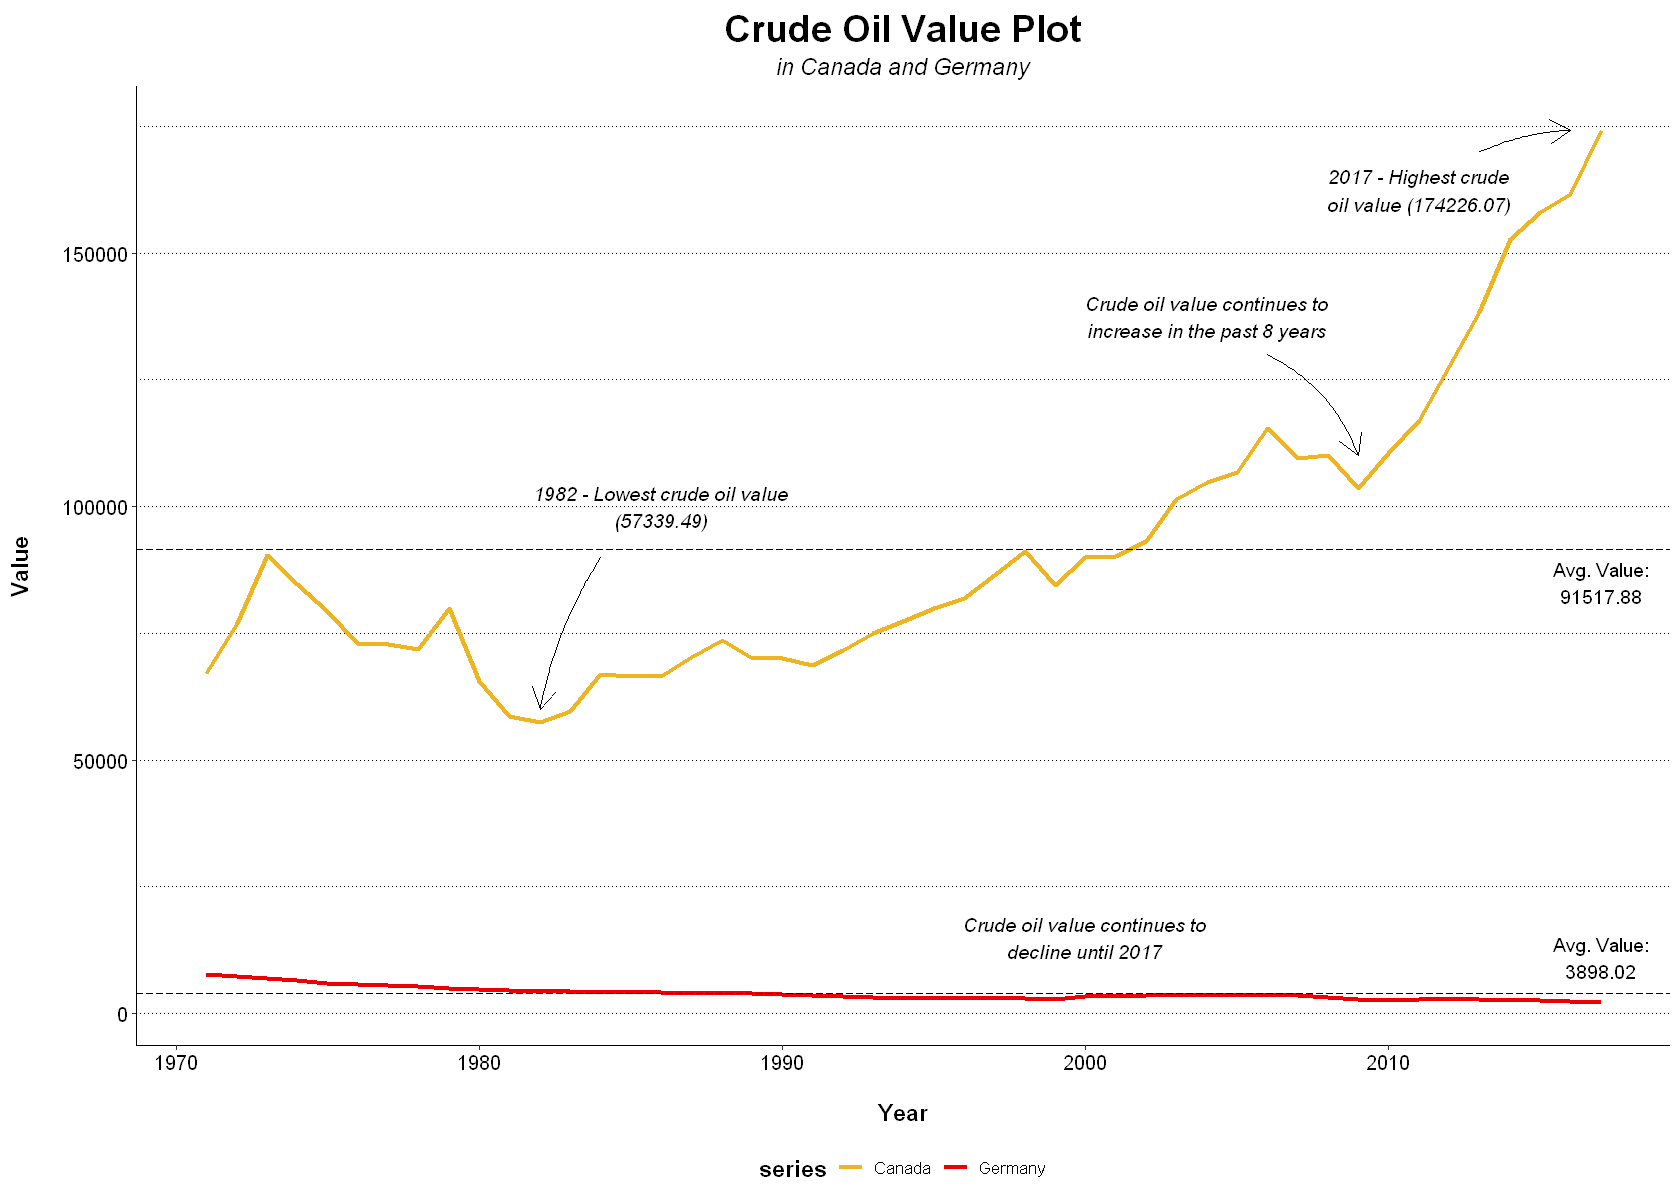

In [4]:
# --- New Dataframes ---
myts_can = ts(oil_can$Value, frequency = 1, start = 1971)
myts_deu = ts(oil_deu$Value, frequency = 1, start = 1971)

# --- Time Series Plot ---
autoplot(myts_can, series = 'Canada', lwd = 1.2) +
  autolayer(myts_deu, series = 'Germany', lwd = 1.2) +
  scale_color_manual(values = c('goldenrod2', 'red2')) +  # Canada in #800000, Germany in #B69121
  labs(title = 'Crude Oil Value Plot', x = '\nYear', y = 'Value\n', subtitle = 'in Canada and Germany') +
  geom_hline(yintercept = 91517.88, linetype = 'longdash', color = 'black') +  # Black horizontal line
  annotate('text', x = 2017, y = 85000, label = 'Avg. Value:\n91517.88', size = 4, color = 'black') +  # Black annotation
  annotate('text', x = 1986, y = 100000, label = '1982 - Lowest crude oil value\n(57339.49)', size = 4, fontface = 'italic', 
           color = 'black') +  # Black annotation
  annotate(geom = 'curve', x = 1984, y = 90000, xend = 1982, yend = 60000, curvature = 0.1, arrow = arrow(length = unit(0.5, 'cm')),
           color = 'black') +  # Black arrow
  annotate('text', x = 2004, y = 137500, label = 'Crude oil value continues to\nincrease in the past 8 years', size = 4, fontface = 'italic', 
           color = 'black') +  # Black annotation
  annotate(geom = 'curve', x = 2006, y = 130000, xend = 2009, yend = 110000, curvature = -0.2, arrow = arrow(length = unit(0.5, 'cm')),
           color = 'black') +  # Black arrow
  annotate('text', x = 2011, y = 162500, label = '2017 - Highest crude\noil value (174226.07)', size = 4, fontface = 'italic', 
           color = 'black') +  # Black annotation
  annotate(geom = 'curve', x = 2013, y = 170000, xend = 2016, yend = 174300, curvature = -0.1, arrow = arrow(length = unit(0.5, 'cm')),
           color = 'black') +  # Black arrow
  geom_hline(yintercept = 3898.02, linetype = 'longdash', color = 'black') +  # Black horizontal line
  annotate('text', x = 2017, y = 11000, label = 'Avg. Value:\n3898.02', size = 4, color = 'black') +  # Black annotation
  annotate('text', x = 2000, y = 15000, label = 'Crude oil value continues to\ndecline until 2017', size = 4, fontface = 'italic', 
           color = 'black') +  # Black annotation
  theme(panel.background = element_rect(fill = 'white', colour = 'white'),  # White background
        plot.background = element_rect(fill = 'white', colour = 'white'),  # White plot background
        plot.title = element_text(size = 22, colour = 'black', face = 'bold', hjust = 0.5, vjust = 0.5),  # Black title
        plot.subtitle = element_text(size = 14, colour = 'black', face = 'italic', hjust = 0.5, vjust = 0.5),  # Black subtitle
        plot.caption = element_text(color = 'black', face = 'italic', size = 12),  # Black caption
        panel.grid.major.y = element_line(linetype = 'dotted', colour = 'black'),  # Black grid lines
        panel.grid.minor.y = element_line(linetype = 'dotted', colour = 'black'),  # Black minor grid lines
        panel.grid.major.x = element_blank(), 
        panel.grid.minor.x = element_blank(),  
        axis.title = element_text(size = 14, face = 'bold', colour = 'black'),  # Black axis titles
        axis.text = element_text(size = 12, colour = 'black'),  # Black axis text
        legend.position = 'bottom',
        axis.line = element_line(colour = 'black'),  # Black axis lines
        legend.text = element_text(size = 10, colour = 'black'),  # Black legend text
        legend.title = element_text(colour = 'black', size = 14, face = 'bold'),  # Black legend title
        legend.background = element_rect(fill = 'white', linetype = 'blank'))  # White legend background


🇨🇦 Canada

It can be seen that there is upward trend with no seasonality.<br>
The time series plot is non-stationary.

🇩🇪 Germany

It can be seen that there is downward trend with no seasonality.<br>
The time series plot is stationary.


### 5.2 Statistical and Non-Statistical Tests
In order to prove that this time series plot is non-stationary or stationary, several statistical tests will be carried out.
Statistical tests that will be carried out are the Mann-Kendall trend test, autocorrelation function (ACF) plot, unit root test, and non-statistical test using the 'ndiffs' and 'nsdiffs' functions.


### 5.2.1 Mann-Kendall Trend Test

Mann-Kendall trend test hypothesis:

H0: There is no trend available in the series.
H1: There is a trend available in the series.

Criteria:
If the p-value is less than 0.05, reject H0.

In [ ]:
# --- Mann-Kendall Trend Test (Canada) ---
cat('.: Mann-Kendall Trend Test :.\n')
cat('******************************\n')
cat(' >> Canada ')
trend.test(myts_can)

# --- Mann-Kendall Trend Test (Germany) ---
cat(' >> Germany ')
trend.test(myts_deu)

.: Mann-Kendall Trend Test :.
******************************
 >> Canada 


	Spearman's rank correlation rho

data:  myts_can and time(myts_can)
S = 3334, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8072387 


 >> Germany 


	Spearman's rank correlation rho

data:  myts_deu and time(myts_deu)
S = 33178, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
-0.918247 


🇨🇦 Canada

It can be seen that the p-value for Canada is less than 0.05, which means there is no trend component present in the series.<br>
Conclusion: H0: accepted

🇩🇪 Germany

It can be seen that the p-value for Germany is less than 0.05, which is there is no trend component present in the series.<br>
Conclusion: H0: accepted

### 5.2.2 ACF and PACF Plot

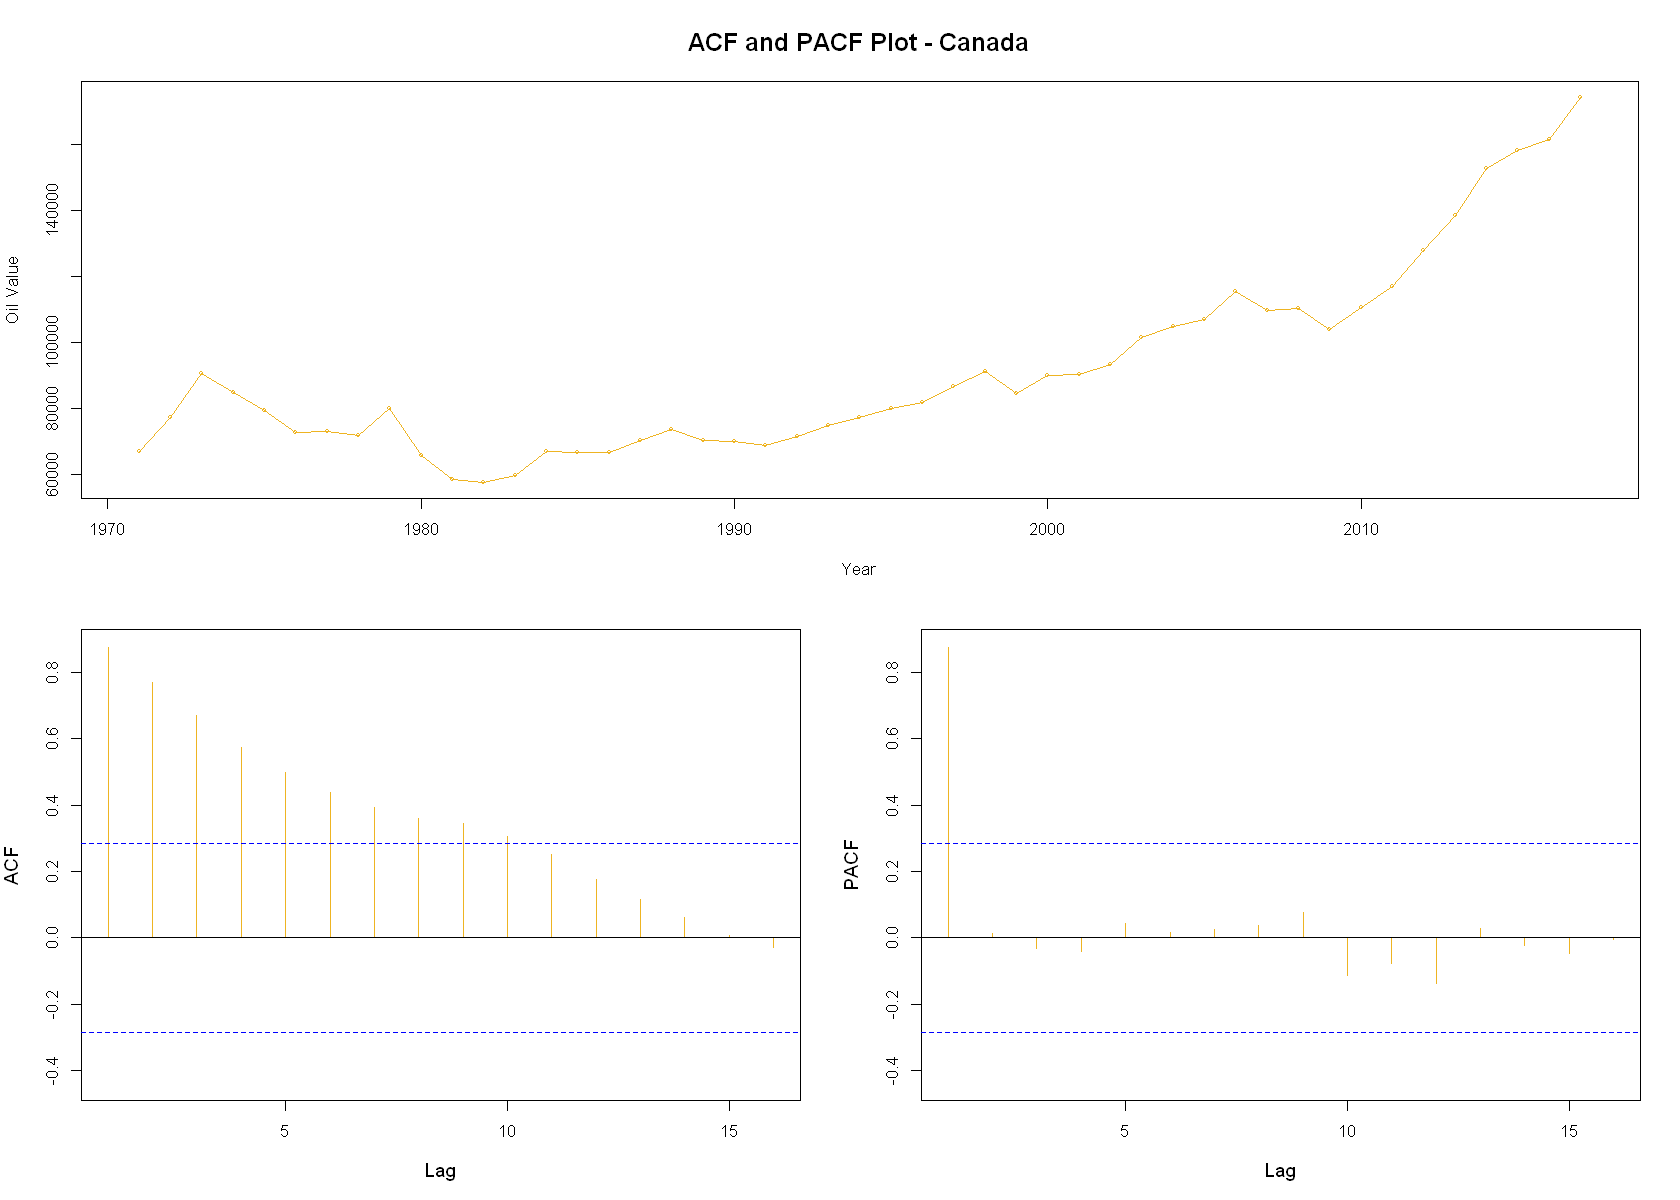

In [6]:
# --- ACF & PACF Plot (Canada) ---
par(bg = 'white', col = 'black', col.main = 'black', col.lab = 'black', col.axis = 'black')
tsdisplay(myts_can, main = 'ACF and PACF Plot - Canada', col = 'goldenrod2', lwd = 1.5, xlab = 'Year', ylab = 'Oil Value', cex.main = 1.5, cex.lab = 1.15)

The series for Canada is not stationary since autocorrelation remains significant for the first several lags. <br>
The ACF plot dies down exceptionally slowly.


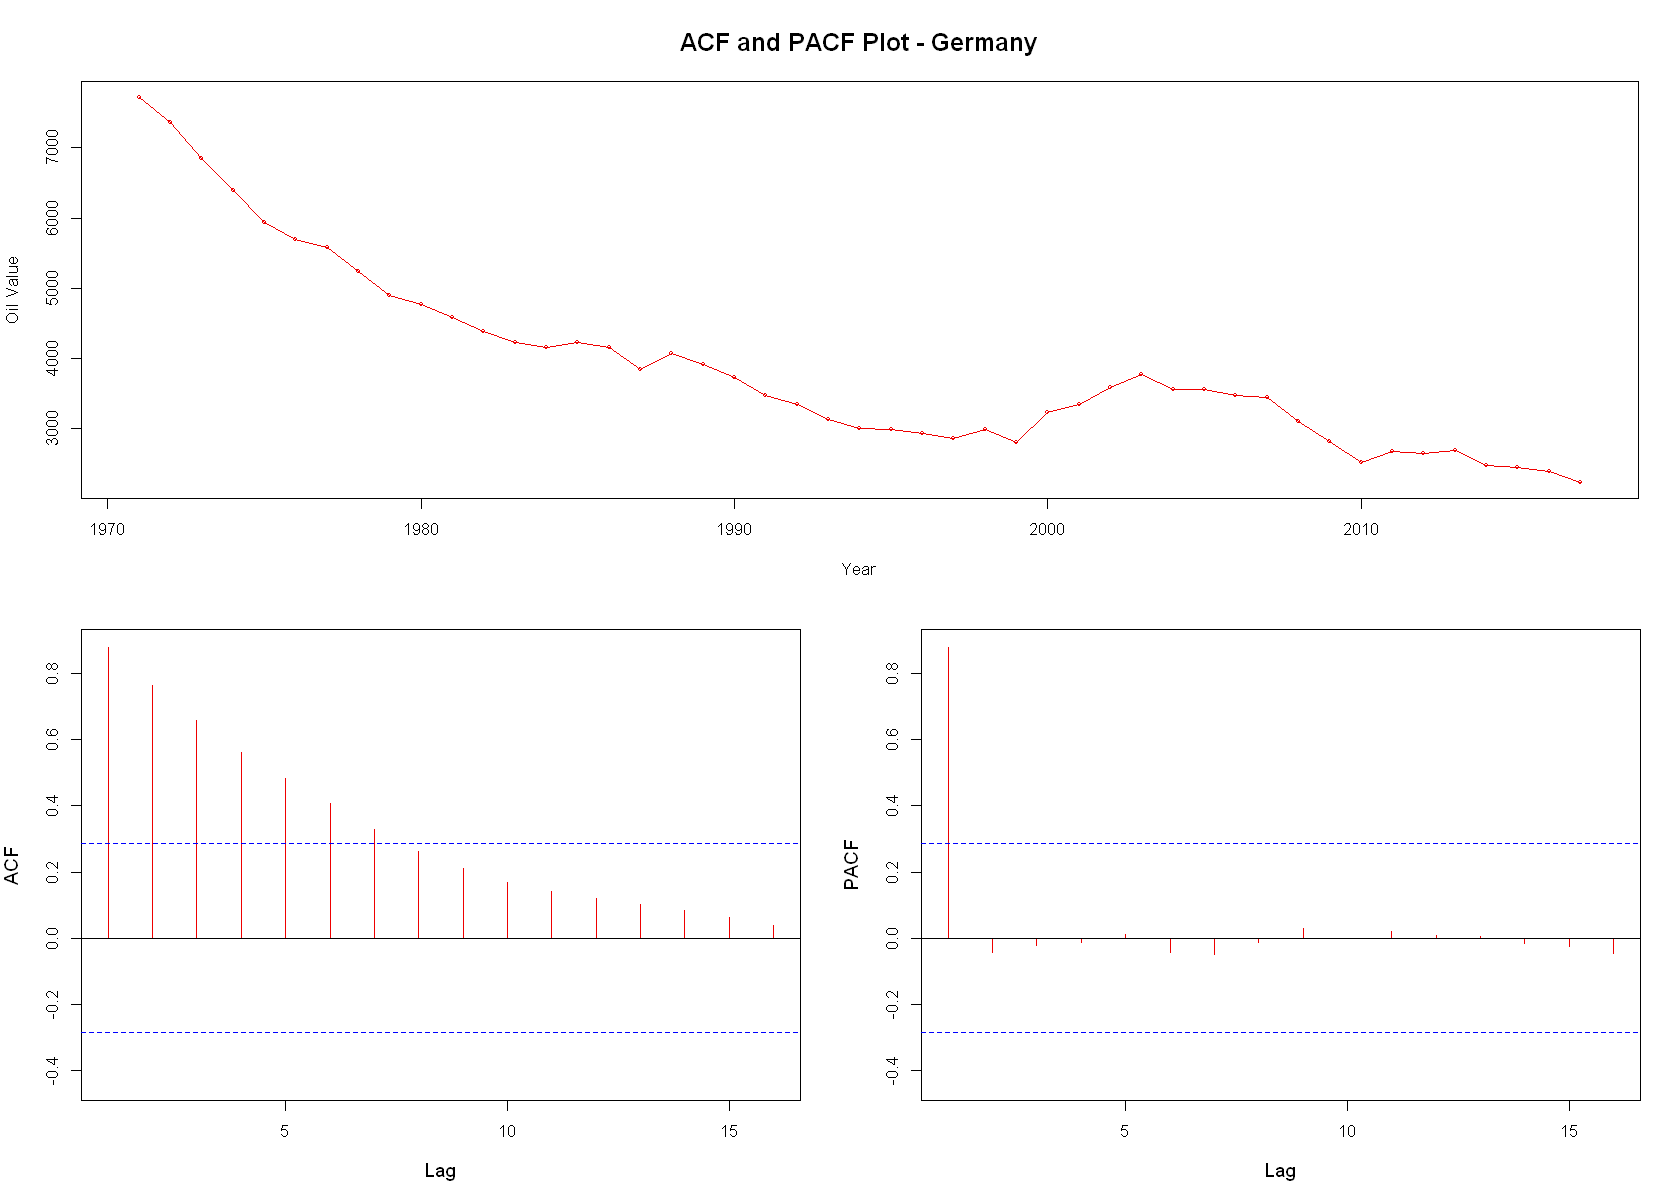

In [7]:
# --- ACF & PACF Plot (Germany) ---
par(bg = 'white', col = 'black', col.main = 'black', col.lab = 'black', col.axis = 'black')
tsdisplay(myts_deu, main = 'ACF and PACF Plot - Germany', col = 'red2', lwd = 1.5, xlab = 'Year', ylab = 'Oil Value', cex.main = 1.5, cex.lab = 1.15)

The series for Germany is not stationary since autocorrelation remains significant for the first several lags.
The ACF plot dies down exceptionally slowly.

### 5.2.3 Unit Root Test 

The unit root tests used are Augmented Dickey-Fuller (ADF) test, Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test, and Canova-Hansen test.


#### 5.2.3.1 ADF Test
ADF test hypothesis:

H0: The series is not stationary.<br>
H1: The series is stationary.

Criteria:
If the p-value is less than 0.05, reject H0.

In [8]:
# --- ADF Test (Canada) ---
cat('.: ADF Test :.\n')
cat('***************\n')
cat(' >> Canada ')
adf.test(myts_can)

# --- ADF Test (Germany) ---
cat(' >> Germany ')
adf.test(myts_deu)

.: ADF Test :.
***************
 >> Canada 


	Augmented Dickey-Fuller Test

data:  myts_can
Dickey-Fuller = -0.031821, Lag order = 3, p-value = 0.99
alternative hypothesis: stationary


 >> Germany 


	Augmented Dickey-Fuller Test

data:  myts_deu
Dickey-Fuller = -2.4953, Lag order = 3, p-value = 0.3767
alternative hypothesis: stationary


Canada

It can be seen that the p-value for Canada is greater than 0.05 (0.99), which can be concluded that the series is not stationary.<br>
Conclusion: H₀ accepted

Germany:

It can be seen that the p-value for Germany is greater than 0.05 (0.37), which can be concluded that the series is not stationary.<br>
Conclusion: H₀ accepted

#### 5.2.3.2 KPSS Test

KPSS test hypothesis:

H₀: The series is not stationary.<br>
H₁: The series is stationary.

Criteria:

If the p-value is less than 0.05, reject H₀.<br>
If the value of the test statistic is greater than the critical value, reject H₀.

In [ ]:
# --- KPSS Test (Canada) ---
cat('.: KPSS Test :.\n')
cat('****************\n')
cat(' >> Canada ')
kpss.test(myts_can)
myts_can %>% ur.kpss() %>% summary

# --- KPSS Test (Germany) ---
cat(' >> Germany ')
kpss.test(myts_deu)
myts_deu %>% ur.kpss() %>% summary

.: KPSS Test :.
****************
 >> Canada 


	KPSS Test for Level Stationarity

data:  myts_can
KPSS Level = 0.99685, Truncation lag parameter = 3, p-value = 0.01



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 3 lags. 

Value of test-statistic is: 0.9969 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


 >> Germany 


	KPSS Test for Level Stationarity

data:  myts_deu
KPSS Level = 1.0463, Truncation lag parameter = 3, p-value = 0.01



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 3 lags. 

Value of test-statistic is: 1.0463 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


Canada:

It can be seen that the p-value for Canada is smaller than 0.05 (0.01).<br>
The test-statistic value is more significant than the critical value (0.9969 greater than 0.463).<br>
Conclusion: H₀ accepted

Germany:

It can be seen that the p-value for Germany is smaller than 0.05 (0.01).<br>
The test-statistic value is more significant than the critical value (1.0463 greater than 0.463).<br>
Conclusion: H₀ accepted

### 5.2.4 Non-Statistical Test

The non-statistical test in this section will use the ndiffs and nsdiffs function.

ndiffs function is used to determine the number of non-seasonal differencing needed.

nsdiffs function is used to determine the number of seasonal differencing needed.

In [ ]:
# --- Non-Statistical Test ---
cat('.: Non-Statistical Test :.\n')
cat('***************************\n')
cat(' >> Canada \n')
cat(reset('\t`ndiffs`: '))
cat(ndiffs(myts_can), '\n')
cat(' >> Germany \n')
cat(reset('\t`ndiffs`: '))
cat(ndiffs(myts_deu))

.: Non-Statistical Test :.
***************************
 >> Canada 
	`ndiffs`: 2 
 >> Germany 
	`ndiffs`: 2

It can be seen that for both countries the number of differencing required to obtain a stationary time series is 2 differencing.

# 6. Forecasting Techniques
In this section, 4 forecasting techniques will be used to forecast crude oil production values for both countries. Those forecasting techniques are:

1. Simple Exponential Smoothing (SES),
2. Holt Method,
3. ETS (Error, Trend, Seasonal), and
4. Naïve Forecast/Moving Average.

But first, data partitioning will be performed before applying the models.

### 6.1 Data Partitioning

The data partitioning ratio is 70:30, where 70% of the dataset is used as training, and the rest (30%) is testing.

In [ ]:
# --- Splitting Dataframe ---
h_can = round(length(myts_can)*0.7, 0)
h_deu = round(length(myts_deu)*0.7, 0)

# --- Canada - Train & Test ---
train_can = window(myts_can, end = 2003)
test_can = window(myts_can, start = 2004)

# --- Germany - Train & Test ---
train_deu = window(myts_deu, end = 2003)
test_deu = window(myts_deu, start = 2004)

# --- Train & Test Detail ---
cat('.: Train-Test Info :.\n')
cat('**********************\n')
cat(' >> Canada \n')
cat(reset('\tTrain size: '))
cat(length(train_can), '\n')
cat(reset('\tTest size: '))
cat(length(test_can), '\n')
cat(' >> Germany \n')
cat(reset('\tTrain size: '))
cat(length(train_deu), '\n')
cat(reset('\tTest size: '))
cat(length(test_deu), '\n')

.: Train-Test Info :.
**********************
 >> Canada 
	Train size: 33 
	Test size: 14 
 >> Germany 
	Train size: 33 
	Test size: 14 


### 6.2 Simple Exponential Smoothing

Simple exponential smoothing (SES) is a practical and straightforward forecasting approach that uses an exponentially weighted average of earlier data to get the prediction. In SES, the time series data assigns declining weights to recent data and less to older data. SES is used to forecast time series when the data lacks trend and seasonality. SES is also limited to estimating the level component. Each parameter’s weight, or weight reduction, is always defined by a smoothing parameter called α (alpha), which values between 0 and 1.

<ul>
α = 0, indicating that future forecasted values are based on the average of past data.<br>
α = 1, indicating that future forecasted values are based on the current observation.<br></ul>
Formula:

<center> F_{t+1}=F_t+α(A_t-F_t)
     <i style="font-size: 14px;">or</i><br>
	    F_{t+1}= αA_t+(1-α)F_{t-1}</center>


with:
<ul>
F = forecast value<br>
α = smoothing constant/parameter<br>
A = observed values<br>
t = given time period</ul>

 >> Canada : 
**************
.: SES Summary :. 


Forecast method: Simple exponential smoothing

Model Information:
Simple exponential smoothing 

Call:
ses(y = train_can, initial = "simple", alpha = 0.8)

  Smoothing parameters:
    alpha = 0.8 

  Initial states:
    l = 67007.824 

  sigma:  5828.136
Error measures:
                   ME     RMSE      MAE      MPE     MAPE     MASE      ACF1
Training set 1236.493 5828.136 4559.323 1.147407 5.979463 1.035264 0.2532003

Forecasts:
     Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2004       99651.25 92182.19 107120.3 88228.31 111074.2
2005       99651.25 90086.19 109216.3 85022.75 114279.7
2006       99651.25 88373.22 110929.3 82403.00 116899.5
2007       99651.25 86888.12 112414.4 80131.73 119170.8
2008       99651.25 85558.66 113743.8 78098.50 121204.0
2009       99651.25 84344.24 114958.3 76241.20 123061.3
2010       99651.25 83219.33 116083.2 74520.79 124781.7
2011       99651.25 82166.64 117135.9 72910.84 126391.7
2012       99651.25 81173.82 118128.7 71392.47 127910.0
20

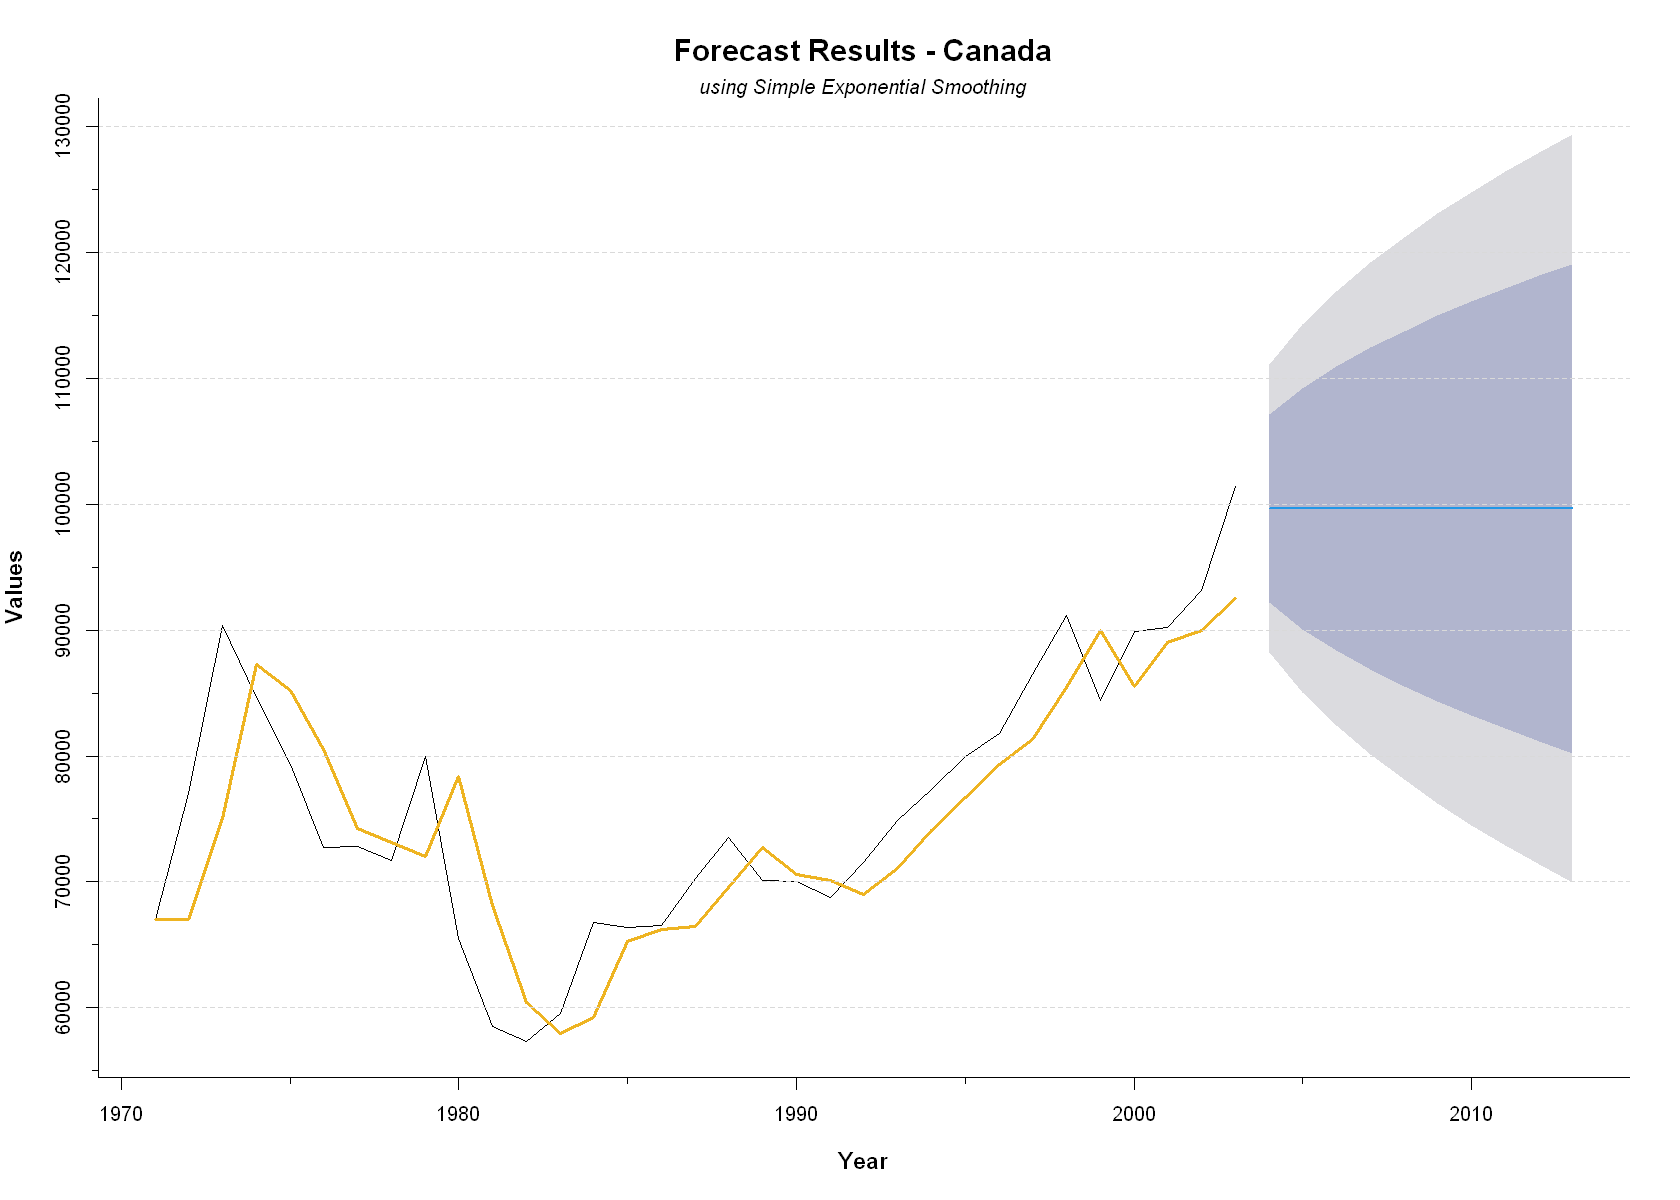

In [12]:
# --- Applying SES (Canada) ---
cat(' >> Canada : \n')
cat('**************\n')
fitses_can = ses(train_can, alpha = 0.8, initial = 'simple')
par(bg = 'white')
plot(forecast(fitses_can, data.frame(test_can, h = length(test_can))), main = '', xlab = '', ylab = '', bty = 'L', col = 'black')
lines(fitted(fitses_can), col = 'goldenrod2', lwd = 2.5)

# --- Plot Settings (Canada) ---
grid(nx = NA, ny = NULL, lty = 2, col = 'gray85', lwd = 1)  # Keep a light gray grid
minor.tick(nx = 2, ny = 2, tick.ratio = 0.5)
title(main = 'Forecast Results - Canada', xlab = 'Year', ylab = 'Values', cex.main = 1.5, cex.lab = 1.15, font.lab = 2, col.main = 'black', col.lab = 'black')
title(main = 'using Simple Exponential Smoothing', cex.main = 1, font.main = 3, line = 0.2, col.main = 'black')

# --- SES Summary (Canada) ---
cat('.: SES Summary :. ')
summary(fitses_can)
cat(reset('\n'))

 >> Germany : 
**************
.: SES Summary :. 


Forecast method: Simple exponential smoothing

Model Information:
Simple exponential smoothing 

Call:
ses(y = train_deu, initial = "simple", alpha = 0.8)

  Smoothing parameters:
    alpha = 0.8 

  Initial states:
    l = 7723.824 

  sigma:  281.4892
Error measures:
                    ME     RMSE     MAE       MPE     MAPE     MASE      ACF1
Training set -151.6778 281.4892 237.831 -2.988587 5.463883 1.130951 0.6027797

Forecasts:
     Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2004       3719.529 3358.786 4080.272 3167.820 4271.238
2005       3719.529 3257.553 4181.505 3012.997 4426.061
2006       3719.529 3174.819 4264.239 2886.467 4552.591
2007       3719.529 3103.091 4335.967 2776.769 4662.289
2008       3719.529 3038.881 4400.177 2678.567 4760.491
2009       3719.529 2980.226 4458.832 2588.863 4850.195
2010       3719.529 2925.895 4513.163 2505.770 4933.288
2011       3719.529 2875.052 4564.007 2428.012 5011.046
2012       3719.529 2827.100 4611.958 2354.677 5084.381
2

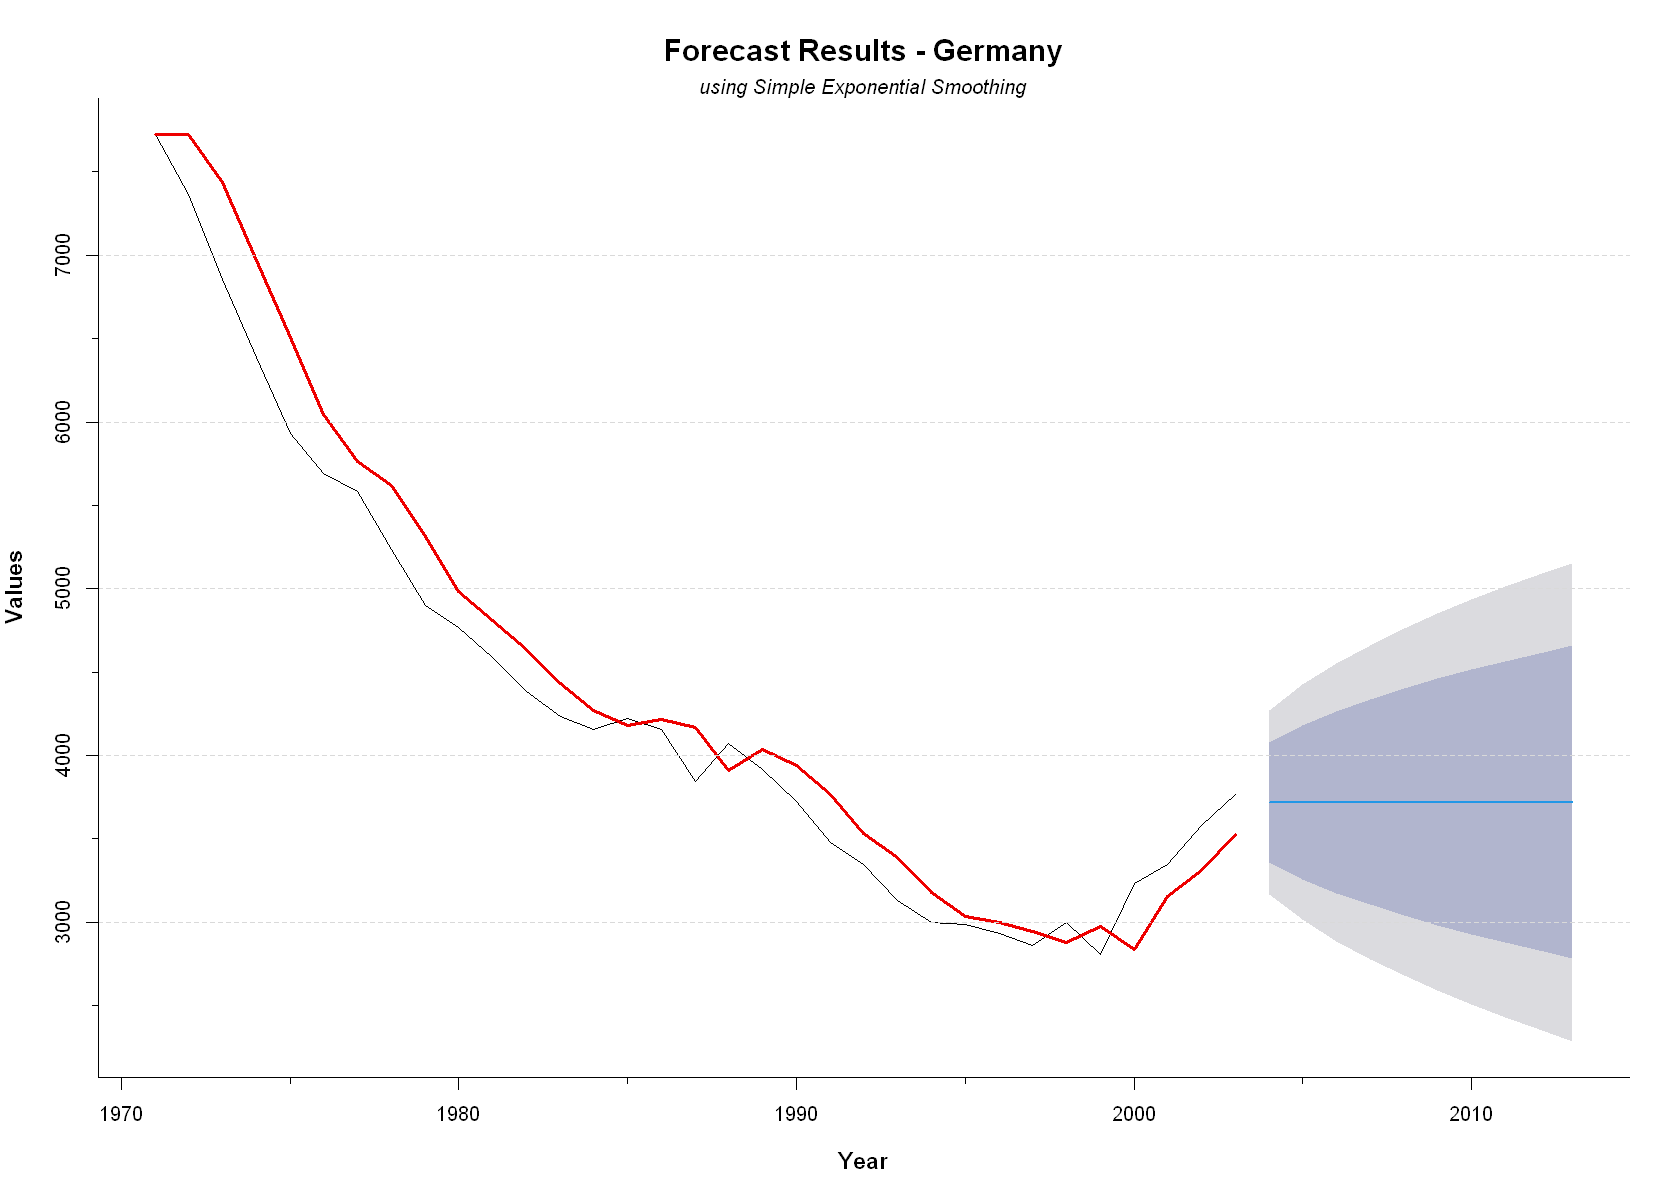

In [13]:
# --- Applying SES (Germany) ---
cat(' >> Germany : \n')
cat('**************\n')
fitses_deu = ses(train_deu, alpha = 0.8, initial = 'simple')
par(bg = 'white')
plot(forecast(fitses_deu, data.frame(test_deu, h = length(test_deu))), main = '', xlab = '', ylab = '', bty = 'L', col = 'black')
lines(fitted(fitses_deu), col = 'red2', lwd = 2.5)

# --- Plot Settings (Germany) ---
grid(nx = NA, ny = NULL, lty = 2, col = 'gray85', lwd = 1)  # Keep a light gray grid
minor.tick(nx = 2, ny = 2, tick.ratio = 0.5)
title(main = 'Forecast Results - Germany', xlab = 'Year', ylab = 'Values', cex.main = 1.5, cex.lab = 1.15, font.lab = 2, col.main = 'black', col.lab = 'black')
title(main = 'using Simple Exponential Smoothing', cex.main = 1, font.main = 3, line = 0.2, col.main = 'black')

# --- SES Summary (Germany) ---
cat('.: SES Summary :. ')
summary(fitses_deu)
cat(reset('\n'))


### 6.3 Holt Method

Holt's smoothing method (referred to as linear exponential smoothing) is a frequently used smoothing model for predicting data with a trend. However, the Holt method fails to perform forecasting when the time series contains seasonal variations. Holt's method involves a forecast equation and two smoothing equations (one for the level and one for the trend).

Forecast Equation:
<center>y_{t+h|t}=l_t+ hb_t</center><br>
Level Equation:
<center>$$ l_t=αy_t+(1-α)(l_{t-1}+b_{t-1}) $$</center><br>
Trend Equation:
<center>$$ b_t=β^*(l_t-l_{t-1})+(1-β^*)b_{t-1} $$</center>
with:
<ul>
     0≤α≤1 = level smoothing parameter<br>
     0≤β^*≤1 = trend smoothing parameter<br>
     b = slope<br>
     t = time period
</ul>

 >> Canada : 
**************
.: Holt Summary :. 


Forecast method: Holt's method

Model Information:
Holt's method 

Call:
holt(y = train_can, initial = "simple")

  Smoothing parameters:
    alpha = 1 
    beta  = 0.2923 

  Initial states:
    l = 67007.824 
    b = 10028.075 

  sigma:  6239.228
Error measures:
                    ME     RMSE      MAE       MPE     MAPE     MASE       ACF1
Training set -651.4512 6239.228 4595.261 -1.010111 6.159791 1.043424 0.02450755

Forecasts:
     Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2004       105185.4 97189.49 113181.3 92956.72 117414.0
2005       108929.0 95863.31 121994.7 88946.76 128911.2
2006       112672.6 94472.04 130873.1 84837.25 140507.9
2007       116416.2 92825.82 140006.6 80337.82 152494.6
2008       120159.8 90878.80 149440.8 75378.38 164941.2
2009       123903.4 88621.69 159185.1 69944.67 177862.2
2010       127647.0 86057.32 169236.7 64041.07 191253.0
2011       131390.6 83192.99 179588.3 57678.70 205102.6
2012       135134.2 80037.45 190231.0 50870.98 219397.5
2

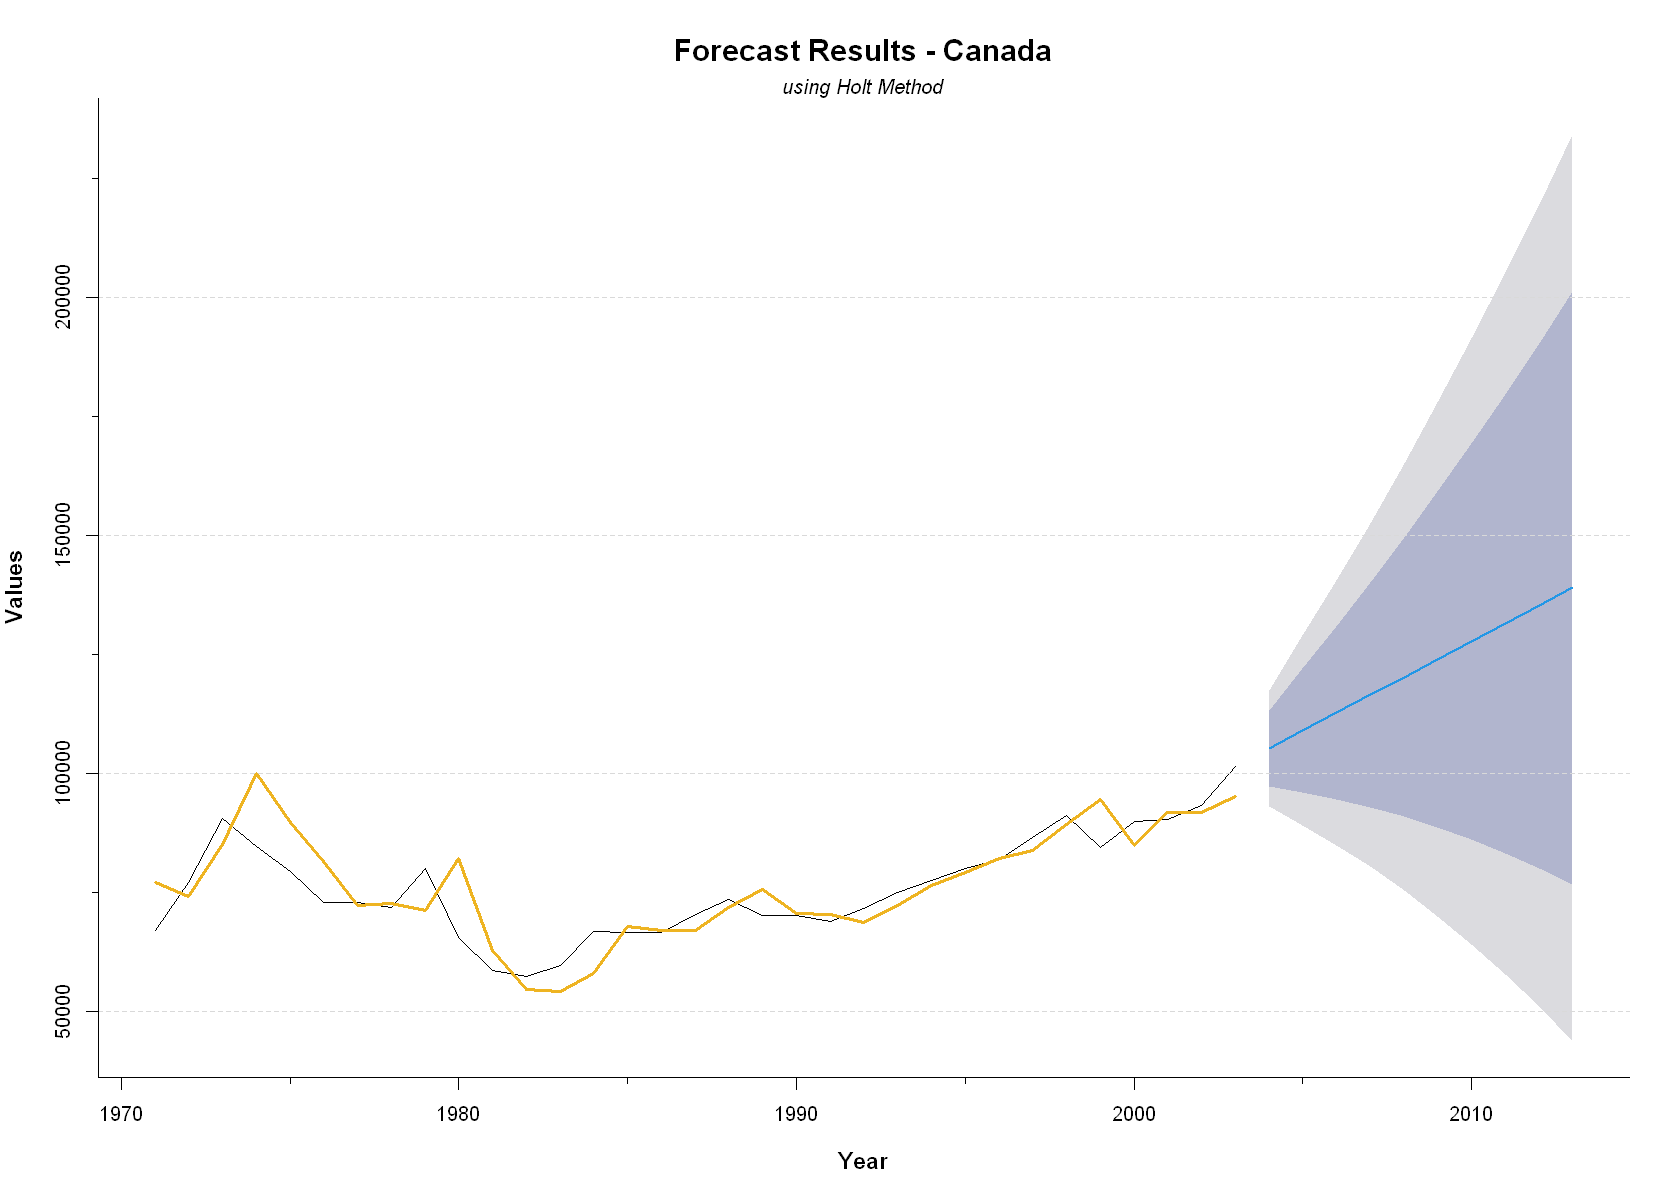

In [14]:
# --- Applying Holt (Canada) ---
cat(' >> Canada : \n')
cat('**************\n')
fitholt_can = holt(train_can, initial = 'simple')
par(bg = 'white')
plot(forecast(fitholt_can, data.frame(test_can, h = length(test_can))), main = '', xlab = '', ylab = '', bty = 'L', col = 'black')
lines(fitted(fitholt_can), col = 'goldenrod2', lwd = 2.5)

# --- Plot Settings (Canada) ---
grid(nx = NA, ny = NULL, lty = 2, col = 'gray85', lwd = 1)  # Keep a light gray grid
minor.tick(nx = 2, ny = 2, tick.ratio = 0.5)
title(main = 'Forecast Results - Canada', xlab = 'Year', ylab = 'Values', cex.main = 1.5, cex.lab = 1.15, font.lab = 2, col.main = 'black', col.lab = 'black')
title(main = 'using Holt Method', cex.main = 1, font.main = 3, line = 0.2, col.main = 'black')

# --- Holt Summary (Canada) ---
cat('.: Holt Summary :. ')
summary(fitholt_can)
cat(reset('\n'))


 >> Germany : 
**************
.: Holt Summary :. 


Forecast method: Holt's method

Model Information:
Holt's method 

Call:
holt(y = train_deu, initial = "simple")

  Smoothing parameters:
    alpha = 0.8428 
    beta  = 0.422 

  Initial states:
    l = 7723.824 
    b = -361.432 

  sigma:  175.7894
Error measures:
                   ME     RMSE      MAE      MPE     MAPE      MASE        ACF1
Training set 46.57846 175.7894 138.8436 1.206016 3.343843 0.6602392 -0.04821832

Forecasts:
     Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2004       3948.542 3723.259 4173.826 3604.001 4293.083
2005       4133.814 3770.574 4497.054 3578.286 4689.341
2006       4319.085 3793.391 4844.779 3515.105 5123.065
2007       4504.356 3795.792 5212.921 3420.700 5588.013
2008       4689.628 3780.149 5599.107 3298.700 6080.555
2009       4874.899 3748.092 6001.706 3151.596 6598.202
2010       5060.171 3700.843 6419.498 2981.258 7139.083
2011       5245.442 3639.372 6851.512 2789.170 7701.714
2012       5430.713 3564.476 7296.951 2576.550 8284.877

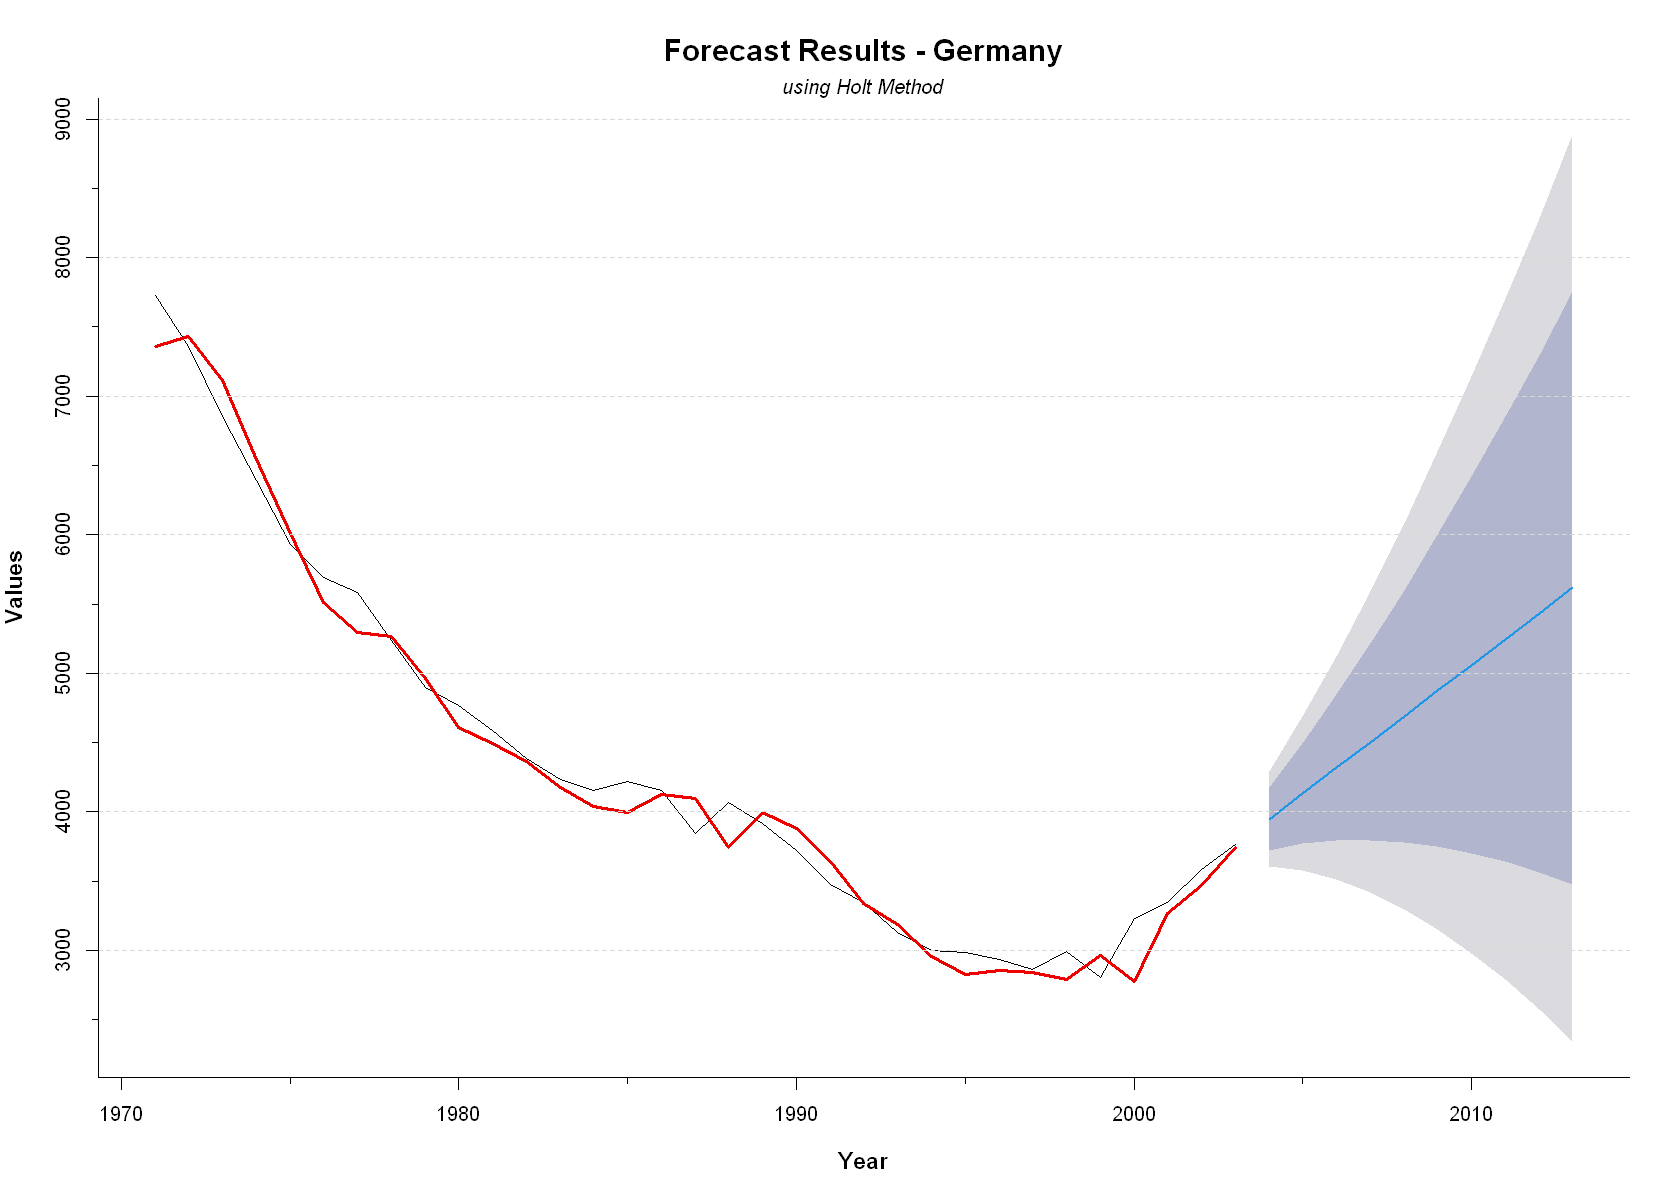

In [15]:
# --- Applying Holt (Germany) ---
cat(' >> Germany : \n')
cat('**************\n')
fitholt_deu = holt(train_deu, initial = 'simple')
par(bg = 'white')
plot(forecast(fitholt_deu, data.frame(test_deu, h = length(test_deu))), main = '', xlab = '', ylab = '', bty = 'L', col = 'black')
lines(fitted(fitholt_deu), col = 'red2', lwd = 2.5)

# --- Plot Settings (Germany) ---
grid(nx = NA, ny = NULL, lty = 2, col = 'gray85', lwd = 1)  # Keep a light gray grid
minor.tick(nx = 2, ny = 2, tick.ratio = 0.5)
title(main = 'Forecast Results - Germany', xlab = 'Year', ylab = 'Values', cex.main = 1.5, cex.lab = 1.15, font.lab = 2, col.main = 'black', col.lab = 'black')
title(main = 'using Holt Method', cex.main = 1, font.main = 3, line = 0.2, col.main = 'black')

# --- Holt Summary (Germany) ---
cat('.: Holt Summary :. ')
summary(fitholt_deu)
cat(reset('\n'))


### 6.4 ETS (Error, Trend, and Seasonal)

ETS forecasts a future value based on previously calculated (historical) values. The forecast value is a continuation of the chosen timeline's past values. Three parameters are used in this model: Error, Trend, and Seasonal. ETS forecast values are equivalent to the forecast distributions' medians.

 >> Canada : 
**************
.: ETS Summary :. 

ETS(M,N,N) 

Call:
ets(y = train_can)

  Smoothing parameters:
    alpha = 0.9999 

  Initial states:
    l = 76120.3458 

  sigma:  0.0793

     AIC     AICc      BIC 
692.6571 693.4847 697.1466 

Training set error measures:
                   ME     RMSE      MAE       MPE    MAPE     MASE       ACF1
Training set 767.3676 5827.863 4546.747 0.5738026 5.97587 1.032409 0.01688343

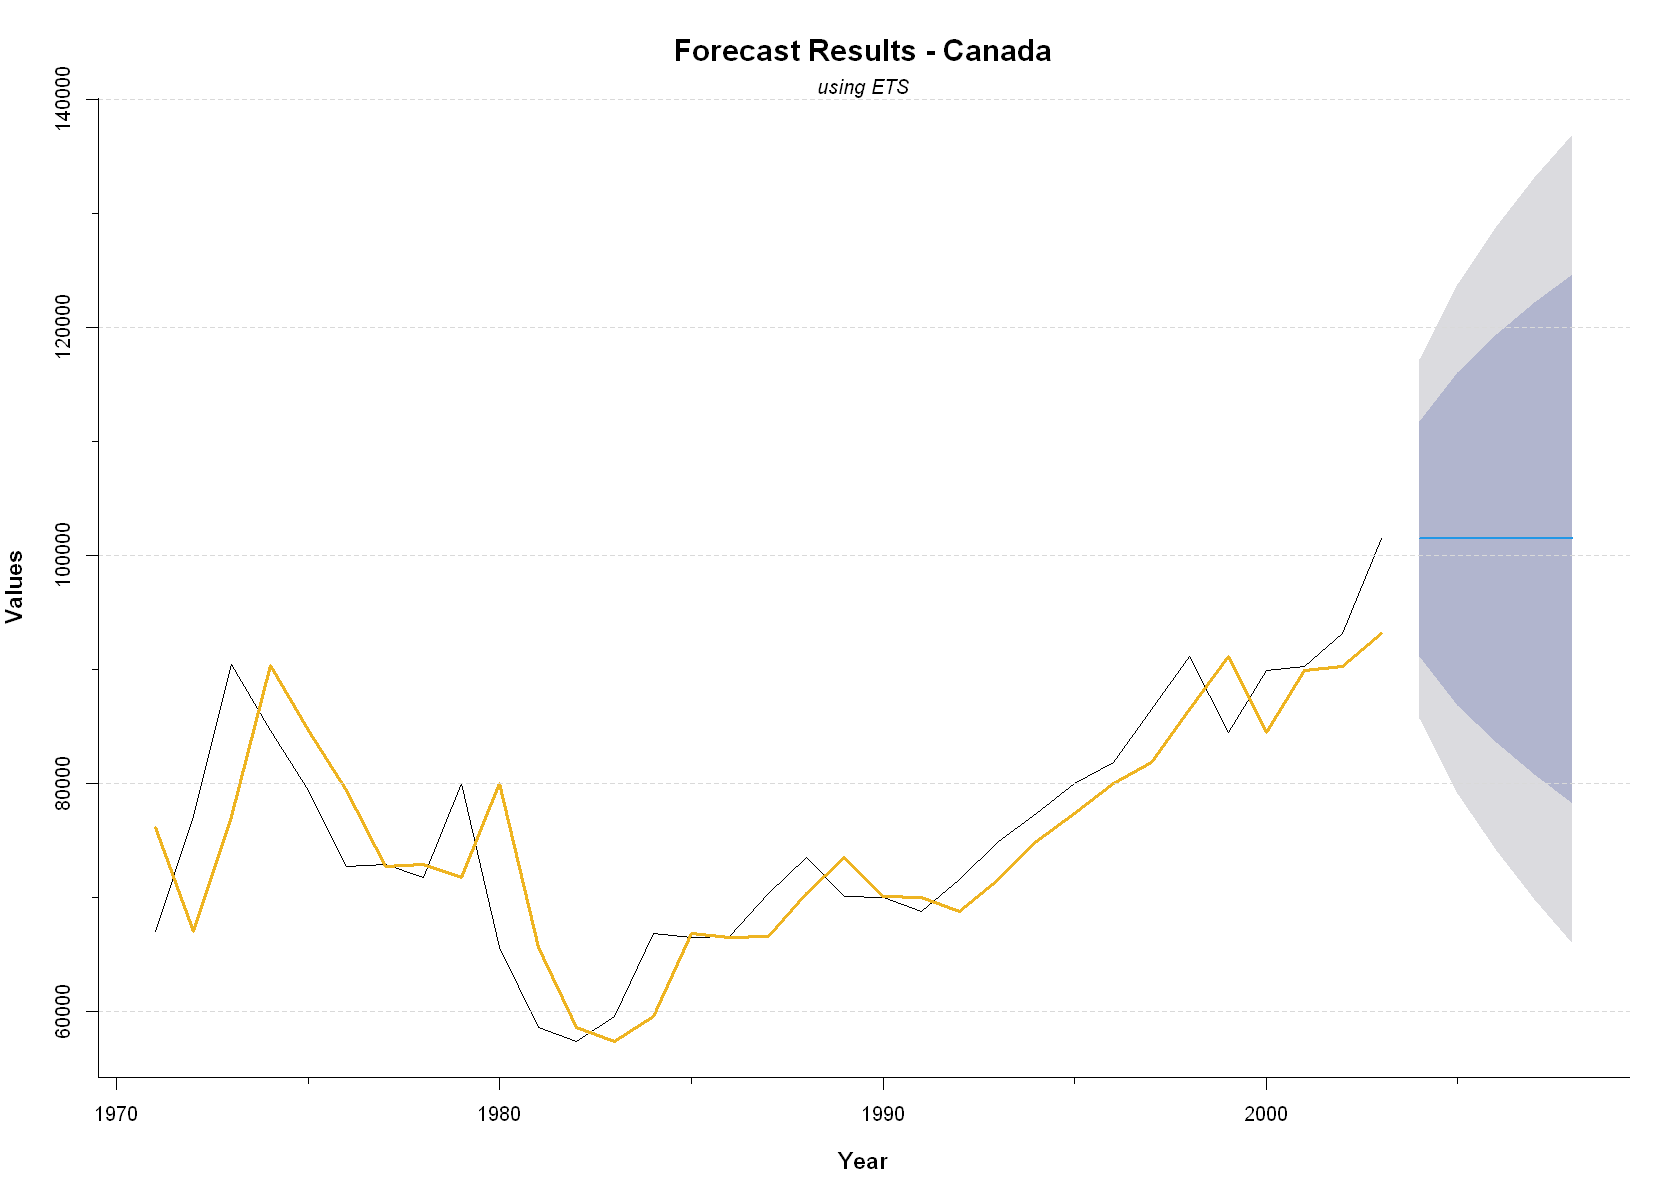

In [16]:
# --- Applying ETS (Canada) ---
cat(' >> Canada : \n')
cat('**************\n')
ets_can = ets(train_can)
ets_can_forecast = ets(test_can, model = ets_can, use.initial.values = FALSE)
par(bg = 'white')
plot(forecast(ets_can, h = 5), main = '', xlab = '', ylab = '', bty = 'L', col = 'black')
lines(fitted(ets_can), col = 'goldenrod2', lwd = 2.5)

# --- Plot Settings (Canada) ---
grid(nx = NA, ny = NULL, lty = 2, col = 'gray85', lwd = 1)  # Keep a light gray grid
minor.tick(nx = 2, ny = 2, tick.ratio = 0.5)
title(main = 'Forecast Results - Canada', xlab = 'Year', ylab = 'Values', cex.main = 1.5, cex.lab = 1.15, font.lab = 2, col.main = 'black', col.lab = 'black')
title(main = 'using ETS', cex.main = 1, font.main = 3, line = 0.2, col.main = 'black')

# --- ETS Summary (Canada) ---
cat('.: ETS Summary :. ')
summary(ets_can)
cat(reset('\n'))

 >> Germany : 
**************
.: ETS Summary :. 

ETS(A,A,N) 

Call:
ets(y = train_deu)

  Smoothing parameters:
    alpha = 0.5541 
    beta  = 0.4904 

  Initial states:
    l = 8243.654 
    b = -483.6936 

  sigma:  163.9537

     AIC     AICc      BIC 
457.6933 459.9156 465.1759 

Training set error measures:
                   ME     RMSE      MAE      MPE     MAPE      MASE       ACF1
Training set 44.55097 153.6963 114.3732 1.099157 2.951933 0.5438756 -0.0209253

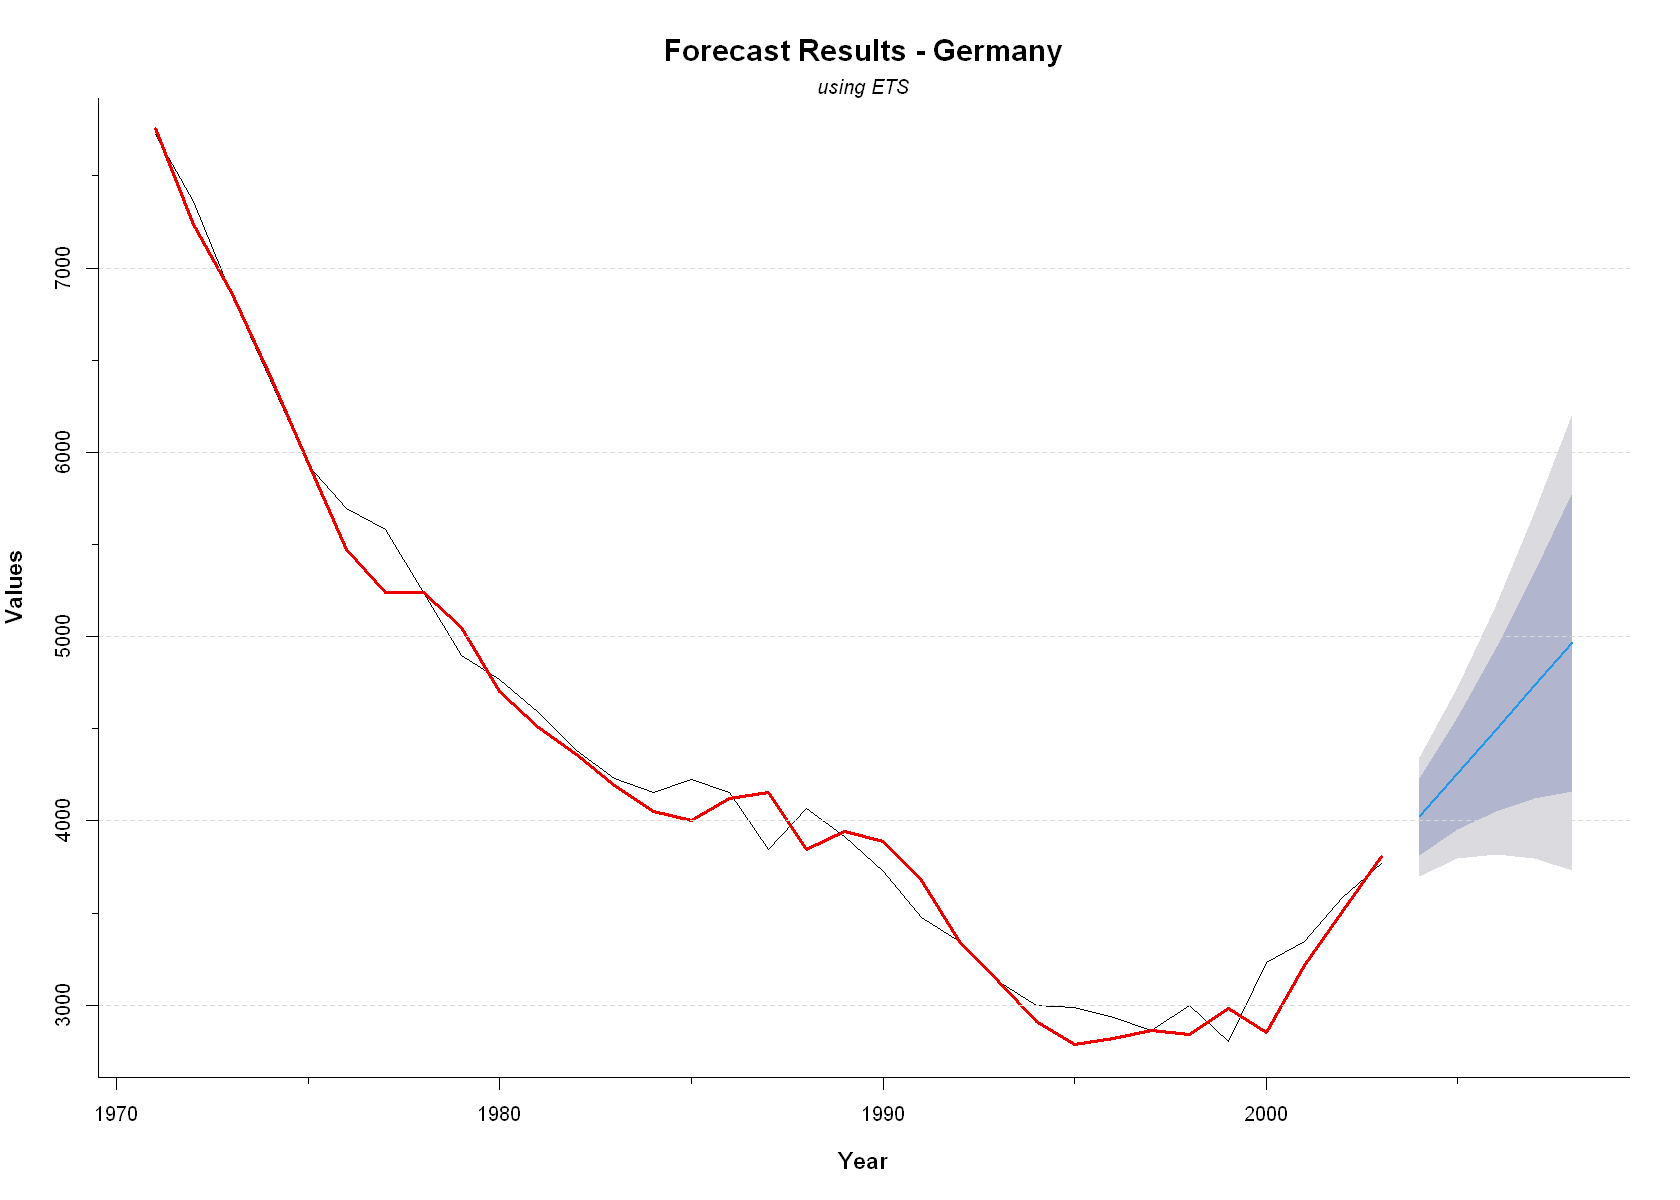

In [17]:
# --- Applying ETS (Germany) ---
cat(' >> Germany : \n')
cat('**************\n')
ets_deu = ets(train_deu)
ets_deu_forecast = ets(test_deu, model = ets_deu, use.initial.values = FALSE)
par(bg = 'white')
plot(forecast(ets_deu, h = 5), main = '', xlab = '', ylab = '', bty = 'L', col = 'black')
lines(fitted(ets_deu), col = 'red2', lwd = 2.5)

# --- Plot Settings (Germany) ---
grid(nx = NA, ny = NULL, lty = 2, col = 'gray85', lwd = 1)  # Keep a light gray grid
minor.tick(nx = 2, ny = 2, tick.ratio = 0.5)
title(main = 'Forecast Results - Germany', xlab = 'Year', ylab = 'Values', cex.main = 1.5, cex.lab = 1.15, font.lab = 2, col.main = 'black', col.lab = 'black')
title(main = 'using ETS', cex.main = 1, font.main = 3, line = 0.2, col.main = 'black')

# --- ETS Summary (Germany) ---
cat('.: ETS Summary :. ')
summary(ets_deu)
cat(reset('\n'))


### 6.5 Naive Forecast/Moving Average

The Naïve model is the simplest method, assuming that the forecast for the next period is the same as the actual value of the previous period. This method is the simplest method since it assumes that the data that has just happened is the most accurate prediction for predicting the future period. However, it does not display any pronounced behavior, such as trend or seasonal pattern.

 >> Canada : 
**************
.: MA Summary :. 


Forecast method: Naive method

Model Information:
Call: naive(y = train_can) 

Residual sd: 5694.7495 

Error measures:
                   ME    RMSE      MAE      MPE     MAPE MASE     ACF1
Training set 1076.061 5694.75 4404.019 1.016679 5.737568    1 0.111976

Forecasts:
     Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2004       101441.8 94143.66 108739.9 90280.27 112603.3
2005       101441.8 91120.68 111762.9 85657.02 117226.5
2006       101441.8 88801.07 114082.5 82109.48 120774.1
2007       101441.8 86845.54 116038.0 79118.77 123764.8
2008       101441.8 85122.69 117760.9 76483.89 126399.7
2009       101441.8 83565.12 119318.4 74101.79 128781.8
2010       101441.8 82132.78 120750.8 71911.21 130972.3
2011       101441.8 80799.59 122084.0 69872.27 133011.3
2012       101441.8 79547.43 123336.1 67957.26 134926.3
2013       101441.8 78363.11 124520.4 66146.00 136737.5

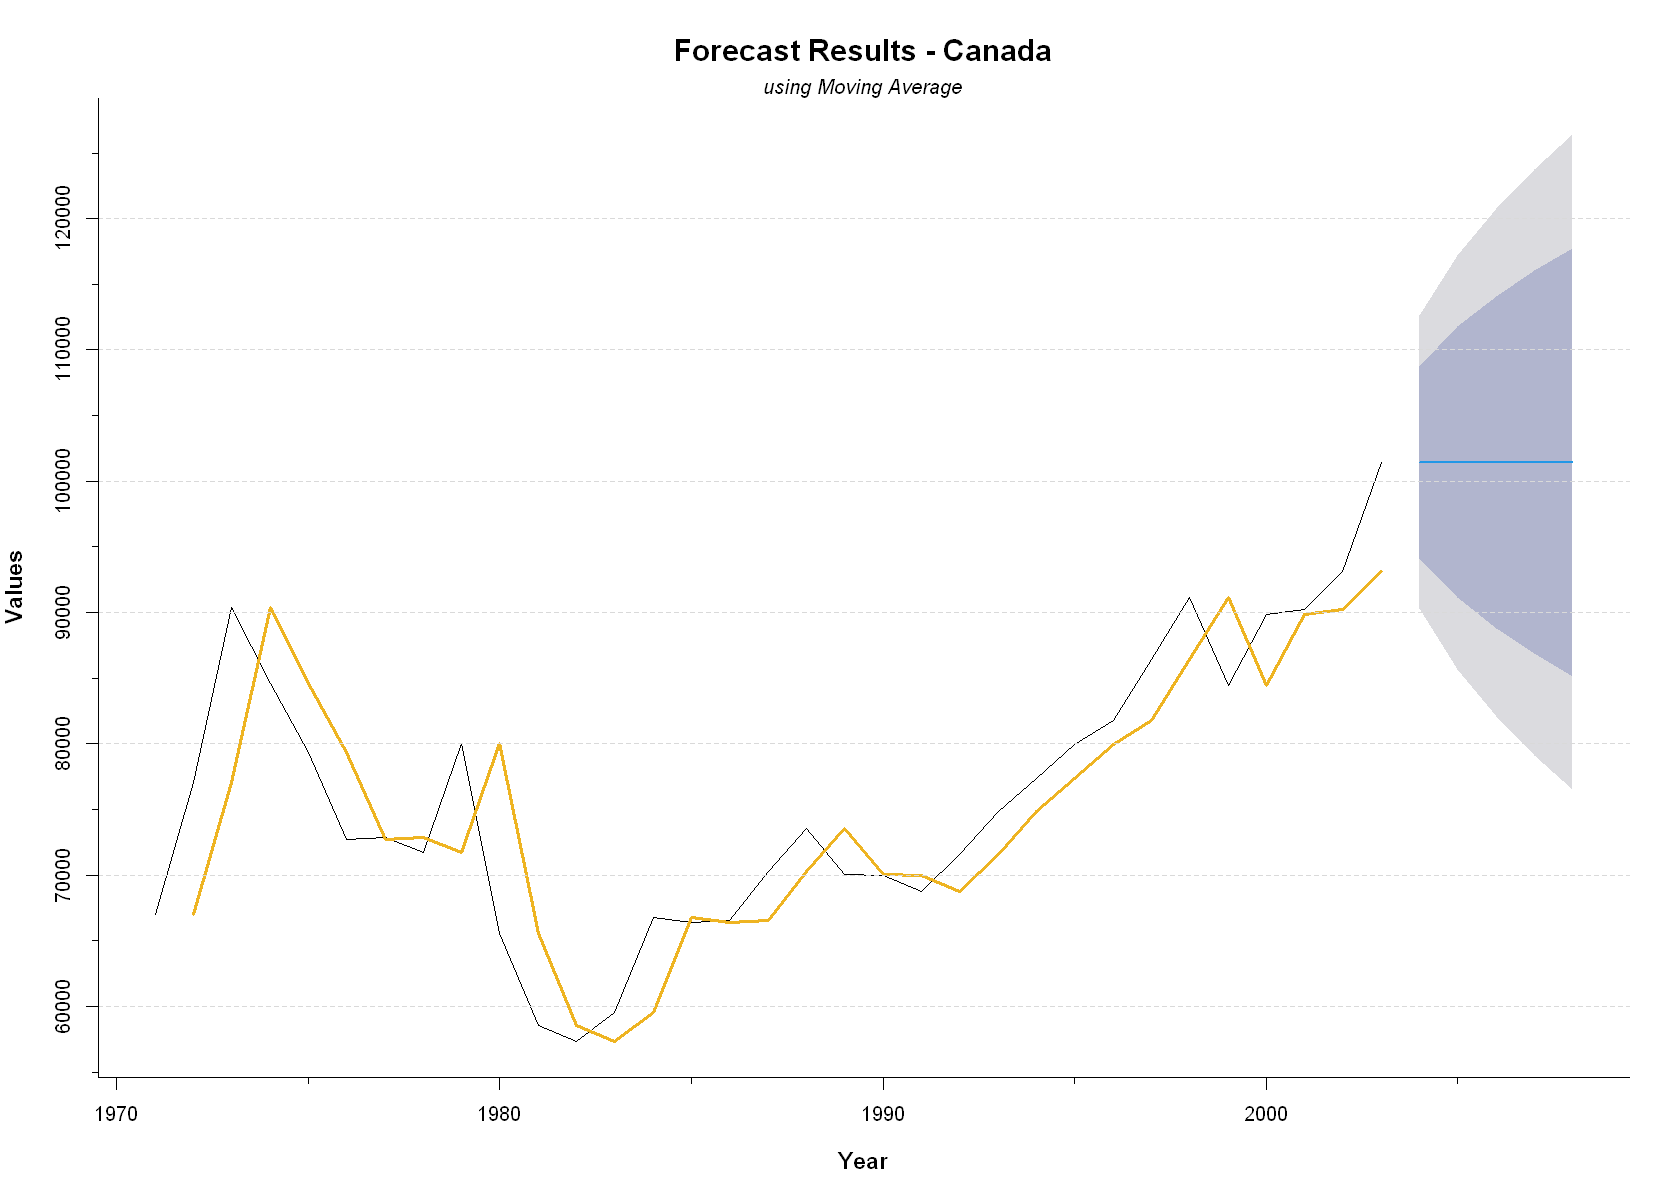

In [18]:
# --- Applying MA (Canada) ---
cat(' >> Canada : \n')
cat('**************\n')
naive_can = naive(train_can)
par(bg = 'white')
plot(forecast(naive_can, h = 5), main = '', xlab = '', ylab = '', bty = 'L', col = 'black')
lines(fitted(naive_can), col = 'goldenrod2', lwd = 2.5)

# --- Plot Settings (Canada) ---
grid(nx = NA, ny = NULL, lty = 2, col = 'gray85', lwd = 1)  # Keep a light gray grid
minor.tick(nx = 2, ny = 2, tick.ratio = 0.5)
title(main = 'Forecast Results - Canada', xlab = 'Year', ylab = 'Values', cex.main = 1.5, cex.lab = 1.15, font.lab = 2, col.main = 'black', col.lab = 'black')
title(main = 'using Moving Average', cex.main = 1, font.main = 3, line = 0.2, col.main = 'black')

# --- MA Summary (Canada) ---
cat('.: MA Summary :. ')
summary(naive_can)
cat(reset('\n'))


 >> Germany : 


**************
.: MA Summary :. 


Forecast method: Naive method

Model Information:
Call: naive(y = train_deu) 

Residual sd: 246.3645 

Error measures:
                    ME     RMSE      MAE       MPE     MAPE MASE      ACF1
Training set -123.6361 246.3645 210.2929 -2.394366 4.873583    1 0.4624619

Forecasts:
     Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2004        3767.47 3451.741 4083.199 3284.604 4250.336
2005        3767.47 3320.962 4213.978 3084.595 4450.345
2006        3767.47 3220.612 4314.328 2931.122 4603.818
2007        3767.47 3136.012 4398.928 2801.739 4733.201
2008        3767.47 3061.479 4473.461 2687.750 4847.190
2009        3767.47 2994.096 4540.844 2584.696 4950.244
2010        3767.47 2932.130 4602.810 2489.928 5045.012
2011        3767.47 2874.454 4660.486 2401.720 5133.220
2012        3767.47 2820.284 4714.656 2318.873 5216.067
2013        3767.47 2769.048 4765.892 2240.515 5294.425

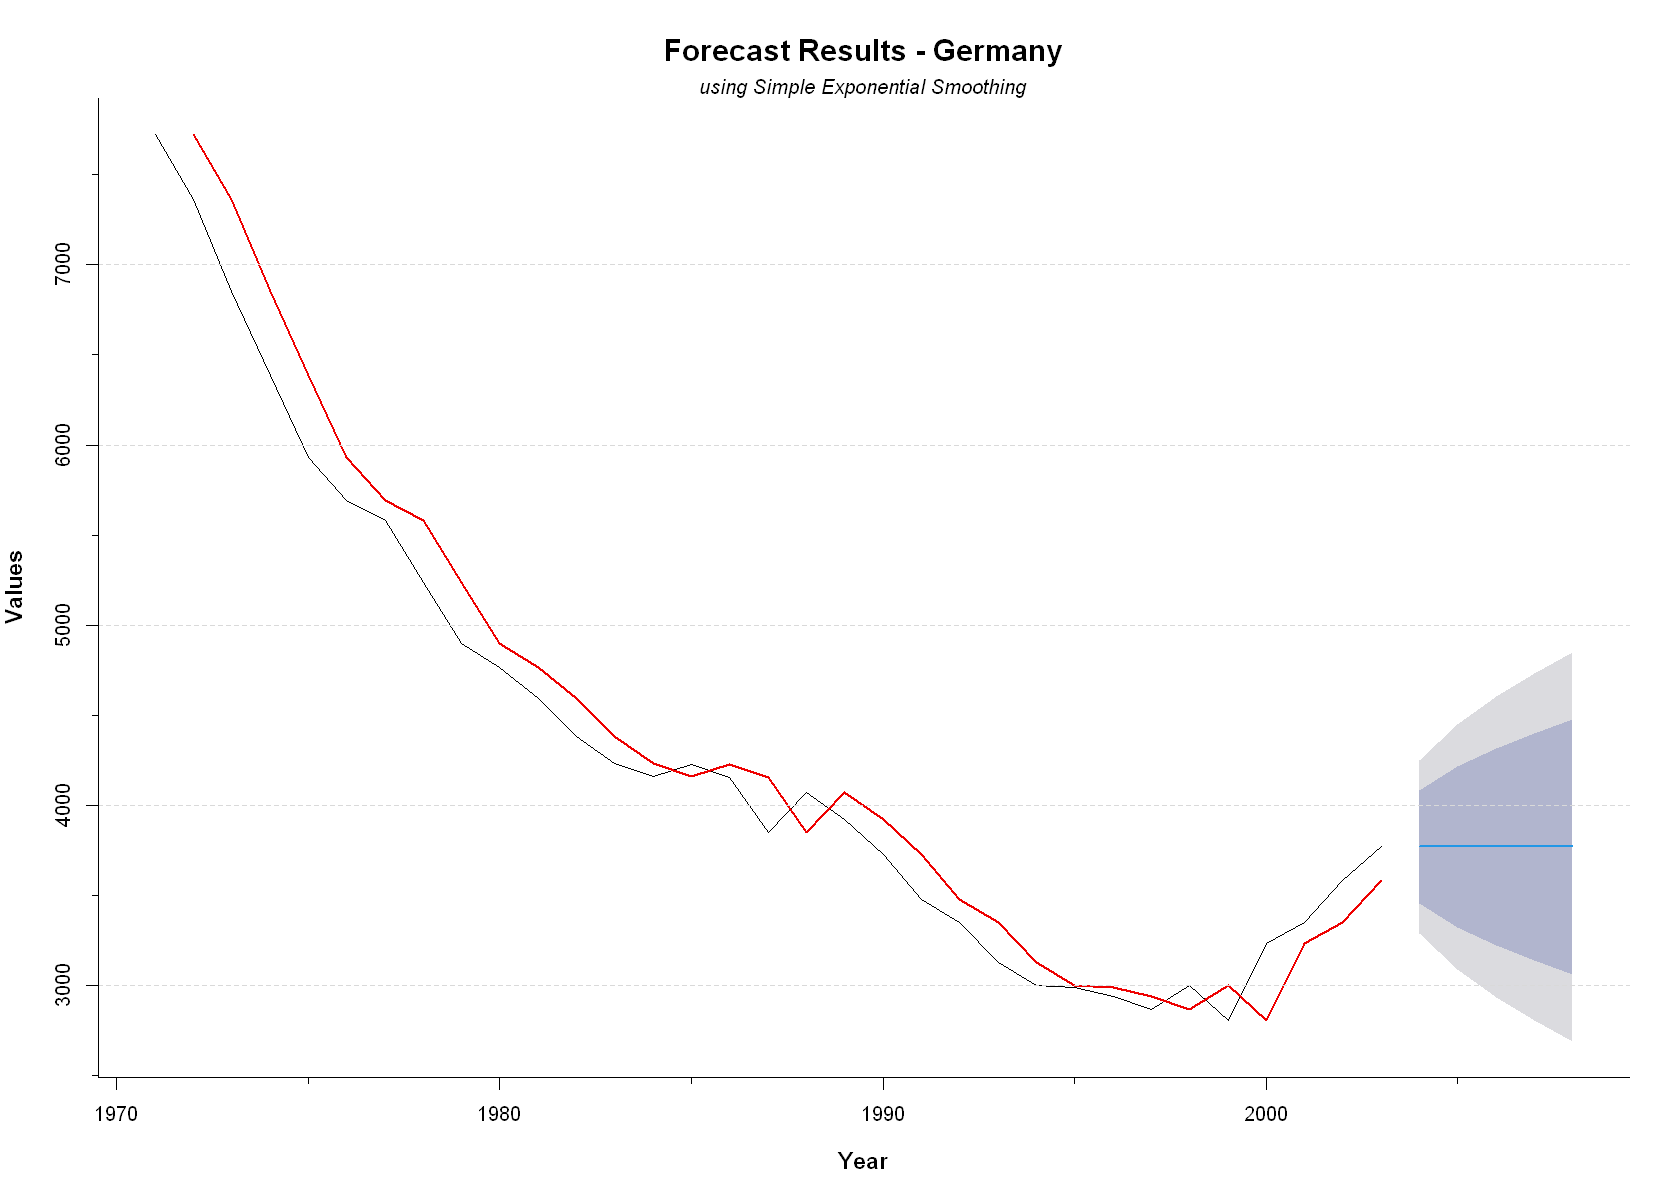

In [19]:
# --- Applying MA (Germany) ---
cat(' >> Germany : \n')
cat('**************\n')
naive_deu = naive(train_deu)
par(bg = 'white')
plot(forecast(naive_deu, h = 5), main = '', xlab = '', ylab = '', bty = 'L', col = 'black')
lines(fitted(naive_deu), col = 'red2', lwd = 2)

# --- Plot Settings (Germany) ---
grid(nx = NA, ny = NULL, lty = 2, col = 'gray85', lwd = 1)  # Keep a light gray grid
minor.tick(nx = 2, ny = 2, tick.ratio = 0.5)
title(main = 'Forecast Results - Germany', xlab = 'Year', ylab = 'Values', cex.main = 1.5, cex.lab = 1.15, font.lab = 2, col.main = 'black', col.lab = 'black')
title(main = 'using Simple Exponential Smoothing', cex.main = 1, font.main = 3, line = 0.2, col.main = 'black')

# --- MA Summary (Germany) ---
cat('.: MA Summary :. ')
summary(naive_deu)
cat(reset('\n'))


### 6.6 Comparison of Forecasting Model 

In [20]:
# --- Comparison Accuracy (Canada) ---
cat(' >> Canada : \n')
cat('**************\n')

# --- SES Accuracy (Canada) ---
cat('.: SES Accuracy :.')
accuracy(fitses_can, test_can)

# --- Holt Method Accuracy (Canada) ---
cat('.: Holt Method Accuracy :.')
accuracy(fitholt_can, test_can)

# --- ETS Accuracy (Canada) ---
cat('.: ETS Accuracy :.')
ets_can_acc = rbind(accuracy(ets_can), accuracy(ets_can_forecast))
rownames(ets_can_acc) <- c('Training Set', 'Test Set')
ets_can_acc

# --- Naive Model Accuracy (Canada) ---
cat('.: Naive Model Accuracy :.')
accuracy(naive_can, test_can)

 >> Canada : 
**************
.: SES Accuracy :.

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,1236.493,5828.136,4559.323,1.147407,5.979463,1.035264,0.2532003,NA
Test set,14716.848,18012.611,14716.848,12.210294,12.210294,3.341686,0.4724096,2.515772


.: Holt Method Accuracy :.

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-651.4512,6239.228,4595.261,-1.010111,6.159791,1.043424,0.02450755,NA
Test set,-7663.5124,10643.487,8227.090,-6.912392,7.400379,1.868087,0.58546667,1.628036


.: ETS Accuracy :.

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training Set,767.3676,5827.863,4546.747,0.5738026,5.975870,1.0324087,0.01688343
Test Set,4985.9911,7934.319,6757.898,3.4763913,5.141536,0.9325808,0.24255024


.: Naive Model Accuracy :.

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,1076.061,5694.75,4404.019,1.016679,5.737568,1.00000,0.1119760,NA
Test set,12926.325,16581.87,12926.325,10.632897,10.632897,2.93512,0.4724096,2.306881


Canada:

<ul>
In general, all 4 models are overfitting, since the RMSE and MAE values for the test are higher compared to training.<br>
However, the RMSE and MAE train and test results produced by the ETS model are better compared to the other three models.<br>
From MAPE results, the ETS model can provide an error percentage of 5.9% for training and 5.1% for testing.
</ul>

In [21]:
# --- Comparison Accuracy (Germany) ---
cat(' >> Germany : \n')
cat('**************\n')

# --- SES Accuracy (Germany) ---
cat('.: SES Accuracy :.')
accuracy(fitses_deu, test_deu)

# --- Holt Method Accuracy (Germany) ---
cat('.: Holt Method Accuracy :.')
accuracy(fitholt_deu, test_deu)

# --- ETS Accuracy (Germany) ---
cat('.: ETS Accuracy :.')
ets_deu_acc = rbind(accuracy(ets_deu), accuracy(ets_deu_forecast))
rownames(ets_deu_acc) <- c('Training Set', 'Test Set')
ets_deu_acc

# --- Naive Model Accuracy (Germany) ---
cat('.: Naive Model Accuracy :.')
accuracy(naive_deu, test_deu)

 >> Germany : 
**************
.: SES Accuracy :.

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-151.6778,281.4892,237.831,-2.988587,5.463883,1.130951,0.6027797,NA
Test set,-672.9970,784.2853,672.997,-24.234747,24.234747,3.200283,0.7821702,4.88072


.: Holt Method Accuracy :.

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,46.57846,175.7894,138.8436,1.206016,3.343843,0.6602392,-0.04821832,NA
Test set,-1735.73143,1962.7312,1735.7314,-61.845243,61.845243,8.2538741,0.75103352,12.20889


.: ETS Accuracy :.

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training Set,44.55097,153.6963,114.3732,1.0991570,2.951933,0.5438756,-0.0209253
Test Set,-18.80508,195.9271,152.4963,-0.6469876,5.608312,1.1592404,0.3778142


.: Naive Model Accuracy :.

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-123.6361,246.3645,210.2929,-2.394366,4.873583,1.000000,0.4624619,NA
Test set,-720.9379,825.7905,720.9379,-25.836006,25.836006,3.428255,0.7821702,5.120702



Germany:

<ul>
In general, all 4 models are overfitting, since the RMSE and MAE values for the test are higher compared to training.<br>
The RMSE and MAE train and test results produced by the ETS model are better compared to the other three models.<br>
From MAPE results, the ETS model can provide an error percentage of 2.9% for training and 5.6% for testing.
</ul>

# 7. ARIMA Models
ARIMA models strongly rely on the data’s autocorrelation pattern. Three items are required to determine the appropriate ARIMA models: the time series, ACF plot, and PACF plot.

ARIMA Formula:
<center> φ_p (B)∇^d Y_t=δ+θ_q (B)ε_t </center><br>

with:
<ul>
    ∇^d = differencing // (1-B)^d<br>
    δ = constant<br>
    ε_t = white noise/random error<br>
    Y_t = time series data<br>
    φ_p (B) = regular AR(p) // 1-φ_1 B-φ_2 B^2-...-φ_p B^p<br>
    θ_q (B) = regular MA(q) // 1+θ_1 B+θ_2 B^2+⋯+θ_q B^q
</ul>

### 7.1 Non-Seasonal Differencing

<ul>
In the previous section, it was already mentioned that non-seasonal differencing is needed for both countries in order to get stationary time series.<br>
This section will perform non-seasonal differencing before applying a suitable ARIMA model.
</ul>

### 7.1.1 ACF and PACF Plot after 2 Non-Seasonal Differencing

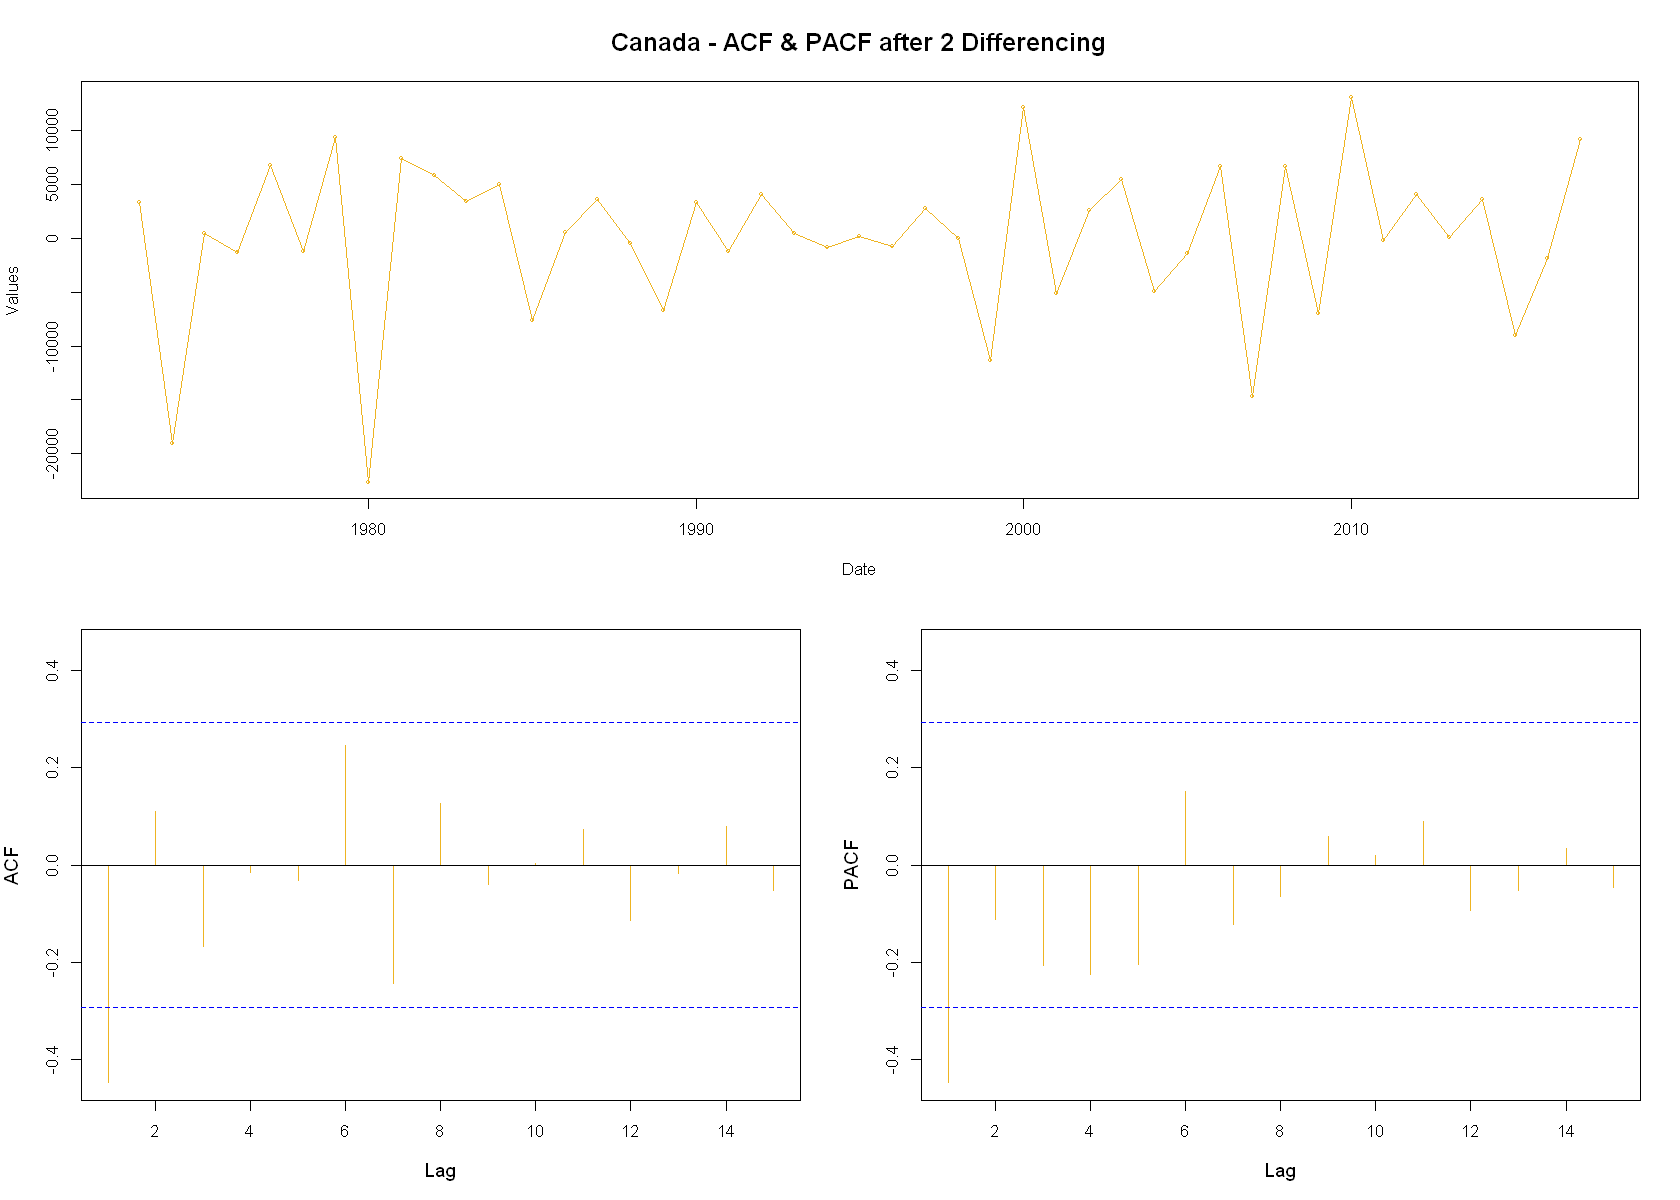

In [22]:
# --- Canada - ACF and PACF after 2 Non-Seasonal Differencing ---
par(bg = 'white') 
tsdisplay(diff(diff(myts_can, 1), 1), main = 'Canada - ACF & PACF after 2 Differencing', col = 'goldenrod2', lwd = 1.5, xlab = 'Date', ylab = 'Values', cex.main = 1.5, cex.lab = 1.15)

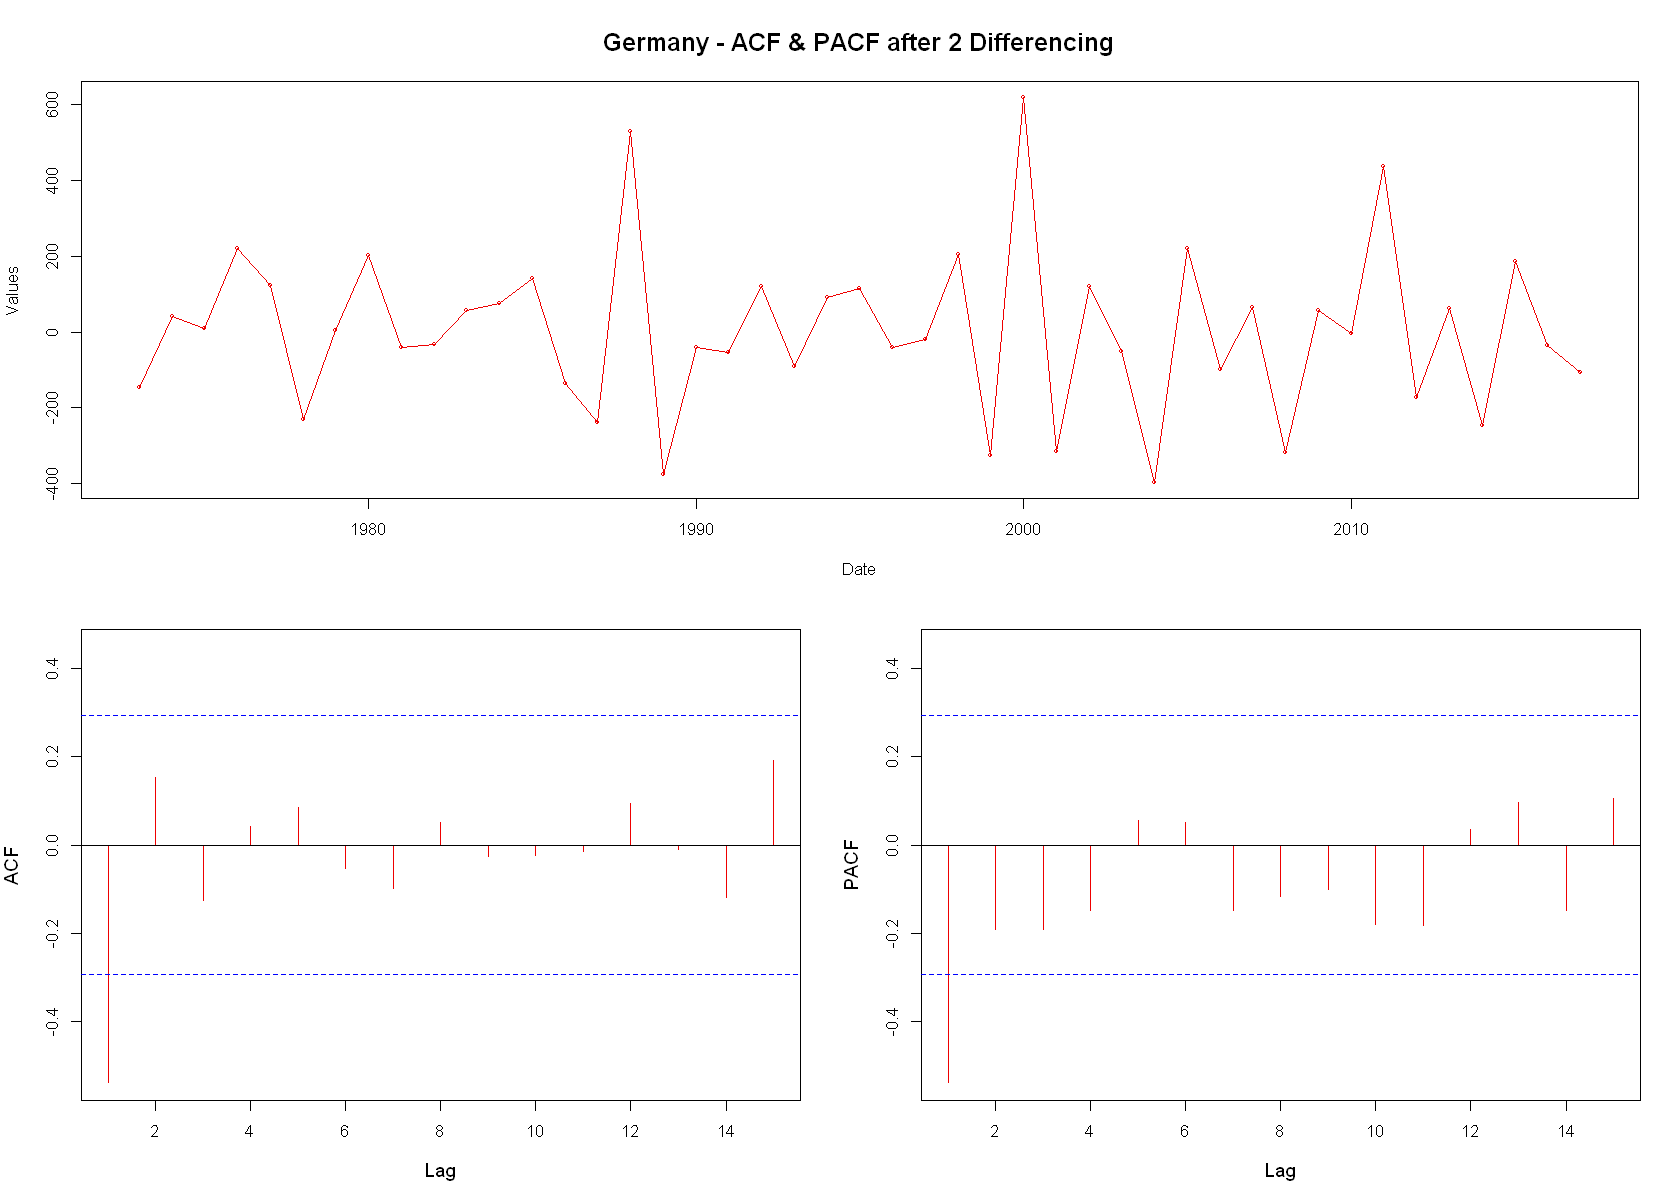

In [23]:
# --- Germany - ACF and PACF after 2 Non-Seasonal Differencing ---
par(bg = 'white') 
tsdisplay(diff(diff(myts_deu,1),1), main = 'Germany - ACF & PACF after 2 Differencing', col = 'red2', lwd = 1.5, xlab = 'Date', ylab = 'Values', cex.main = 1.5, cex.lab = 1.15)

### 7.1.2 KPSS Test after Non-Seasonal Differencing

KPSS test hypothesis:

H₀: The series is not stationary.<br>
H₁: The series is stationary.

Criteria:

If the p-value is less than 0.05, reject H₀.<br>
If the value of the test-statistic is greater than the critical value, reject H₀.

In [24]:
# --- Canada - Differencing Comparison ---
cat(' >> Canada : \n')
cat('**************\n ')
cat('.: 1st Differencing :.')
kpss.test(diff(myts_can, 1))
diff(myts_can, 1) %>% ur.kpss() %>% summary
cat('.: 2nd Differencing :.')
kpss.test(diff(diff(myts_can, 1), 1))
diff(diff(myts_can,1), 1) %>% ur.kpss() %>% summary 

 >> Canada : 
**************
 .: 1st Differencing :.


	KPSS Test for Level Stationarity

data:  diff(myts_can, 1)
KPSS Level = 0.47737, Truncation lag parameter = 3, p-value = 0.04676



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 3 lags. 

Value of test-statistic is: 0.4774 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


.: 2nd Differencing :.


	KPSS Test for Level Stationarity

data:  diff(diff(myts_can, 1), 1)
KPSS Level = 0.13761, Truncation lag parameter = 3, p-value = 0.1



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 3 lags. 

Value of test-statistic is: 0.1376 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


1️⃣ 1st Differencing:

<ul>
The p-value is 0.047, which is less than 0.05.<br>
The test-statistical value is more significant than the critical value (0.4774 bigger than 0.463).<br>
It can be concluded that second differencing is needed.<br>
Conclusion: H₀ accepted
</ul>

2️⃣ 2nd Differencing:

<ul>
The p-value is more significant than 0.1, which is bigger than 0.05.<br>
The test-statistical value is less significant than the critical value (0.1376 smaller than 0.463).<br>
Conclusion: H₀ rejected
</ul>

In [25]:
# --- Germany - Differencing Comparison ---
cat(' >> Germany : \n')
cat('**************\n ')
cat('.: 1st Differencing :.')
kpss.test(diff(myts_deu, 1))
diff(myts_deu, 1) %>% ur.kpss() %>% summary
cat('.: 2nd Differencing :.')
kpss.test(diff(diff(myts_deu, 1), 1))          
diff(diff(myts_deu, 1), 1) %>% ur.kpss() %>% summary 

 >> Germany : 


**************
 .: 1st Differencing :.


	KPSS Test for Level Stationarity

data:  diff(myts_deu, 1)
KPSS Level = 0.50898, Truncation lag parameter = 3, p-value = 0.03964



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 3 lags. 

Value of test-statistic is: 0.509 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


.: 2nd Differencing :.


	KPSS Test for Level Stationarity

data:  diff(diff(myts_deu, 1), 1)
KPSS Level = 0.090472, Truncation lag parameter = 3, p-value = 0.1



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 3 lags. 

Value of test-statistic is: 0.0905 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


1️⃣ 1st Differencing:

<ul>
The p-value is 0.0396, which is less than 0.05.<br>
The test-statistical value is more significant than the critical value (0.509 bigger than 0.463).<br>
It can be concluded that second differencing is needed.<br>
Conclusion: H₀ accepted
</ul>

2️⃣ 2nd Differencing:

<ul>
The p-value is more significant than 0.1, which is bigger than 0.05.<br>
The test-statistical value is less significant than the critical value (0.0905 smaller than 0.463).<br>
Conclusion: H₀ rejected
</ul>

### 7.2 ARIMA Models

The ARIMA models that will be built will be defined based on ACF and PACF plot for both countries.

Canada:

<ul>
ACF: cut off after lag 1 / MA(1)<br>
PACF: cut off after lag 1 / AR(1)<br>
Differencing needed (d) = 2<br>
Conclusion: ARIMA (1,2,1)
</ul>

Germany:

<ul>
ACF: cut off after lag 1 / MA(1)<br>
PACF: cut off after lag 1 / AR(1)<br>
Differencing needed (d) = 2<br>
Conclusion: ARIMA (1,2,1)
</ul>

For comparison purposes, ARIMA(1,2,2) will be used for both countries.

### 7.2.1 ARIMA(1,2,1) 🥇

In [26]:
# --- Canada - ARIMA(1,2,1) ---
arima_can_121 = Arima(myts_can, order = c(1,2,1))

# --- Germany - ARIMA(1,2,1)
arima_deu_121 = Arima(myts_deu, order = c(1,2,1))

### 7.2.2 ARIMA(1,2,2) 🥈

In [27]:
# --- Canada - ARIMA(1,2,2) ---
arima_can_122 = Arima(myts_can, order = c(1,2,2))

# --- Germany - ARIMA(1,2,2)
arima_deu_122 = Arima(myts_deu, order = c(1,2,2))

### 7.3 ARIMA Models Comparison

### 7.3.1 Relative Performance (AIC, AICc, and BIC)
The lower the AIC, AICc, and BIC values, the better ARIMA model.

In [28]:
# --- Canada - ARIMA Summary ---
cat(' >> Canada : \n')
cat('**************\n ')
cat('.: ARIMA 1 Accuracy :.')
summary(arima_can_121)
cat('.: ARIMA 2 Accuracy :.')
summary(arima_can_122) 

 >> Canada : 
**************
 .: ARIMA 1 Accuracy :.

Series: myts_can 
ARIMA(1,2,1) 

Coefficients:
         ar1      ma1
      0.1696  -0.8882
s.e.  0.1766   0.0911

sigma^2 = 37092228:  log likelihood = -455.61
AIC=917.22   AICc=917.8   BIC=922.64

Training set error measures:
                   ME     RMSE      MAE        MPE     MAPE      MASE
Training set 252.8001 5825.414 4299.228 -0.1479867 4.886964 0.8291267
                   ACF1
Training set 0.00569091

.: ARIMA 2 Accuracy :.

Series: myts_can 
ARIMA(1,2,2) 

Coefficients:
          ar1     ma1      ma2
      -0.8972  0.0526  -0.7435
s.e.   0.3939  0.4261   0.3774

sigma^2 = 38788111:  log likelihood = -456.06
AIC=920.12   AICc=921.12   BIC=927.35

Training set error measures:
                   ME    RMSE      MAE        MPE     MAPE     MASE      ACF1
Training set 186.7825 5887.42 4415.271 -0.2168723 5.035719 0.851506 0.1556451

🇨🇦 Canada

It can be concluded that the model ARIMA(1,2,1) has better AIC, AICc, and BIC values.

In [29]:
# --- Germany - ARIMA Summary ---
cat(' >> Germany : \n')
cat('**************\n ')
cat('.: ARIMA 1 Accuracy :.')
summary(arima_deu_121)
cat('.: ARIMA 2 Accuracy :.')
summary(arima_deu_122) 

 >> Germany : 
**************
 .: ARIMA 1 Accuracy :.

Series: myts_deu 
ARIMA(1,2,1) 

Coefficients:
          ar1      ma1
      -0.1665  -0.5389
s.e.   0.2585   0.2405

sigma^2 = 31510:  log likelihood = -296.16
AIC=598.31   AICc=598.9   BIC=603.73

Training set error measures:
                   ME   RMSE      MAE       MPE     MAPE     MASE        ACF1
Training set 15.60203 169.79 125.0024 0.3461047 3.630782 0.664504 -0.01252289

.: ARIMA 2 Accuracy :.

Series: myts_deu 
ARIMA(1,2,2) 

Coefficients:
          ar1      ma1      ma2
      -0.5923  -0.1146  -0.2854
s.e.   0.6413   0.6698   0.4881

sigma^2 = 32077:  log likelihood = -296.04
AIC=600.07   AICc=601.07   BIC=607.3

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE     MASE       ACF1
Training set 16.40772 169.3058 125.0218 0.3611468 3.621867 0.664607 -0.0107404

🇩🇪 Germany
    
It can be concluded that the model ARIMA(1,2,1) has better AIC, AICc, and BIC values.

### 7.3.2 Adequacy

Ljung-Box test will be used to test the adequacy of ARIMA models.

Ljung-Box test hypothesis:

<ul>
H₀: Errors are not independent (model is not adequate).<br>
H₁: Errors are independent (model is adequate).
</ul>
Criteria:
<ul>
If the p-value is less than 0.05, reject H₀.<br>
The histogram of residuals is a normal distribution.<br>
No trend and seasonality in residuals plot.<br>
No correlation between residuals in the ACF plot.
</ul>

 >> Canada : 
**************
 .: ARIMA (1,2,1) Ljung-Box Test :.
	Ljung-Box test

data:  Residuals from ARIMA(1,2,1)
Q* = 4.5109, df = 7, p-value = 0.7194

Model df: 2.   Total lags used: 9



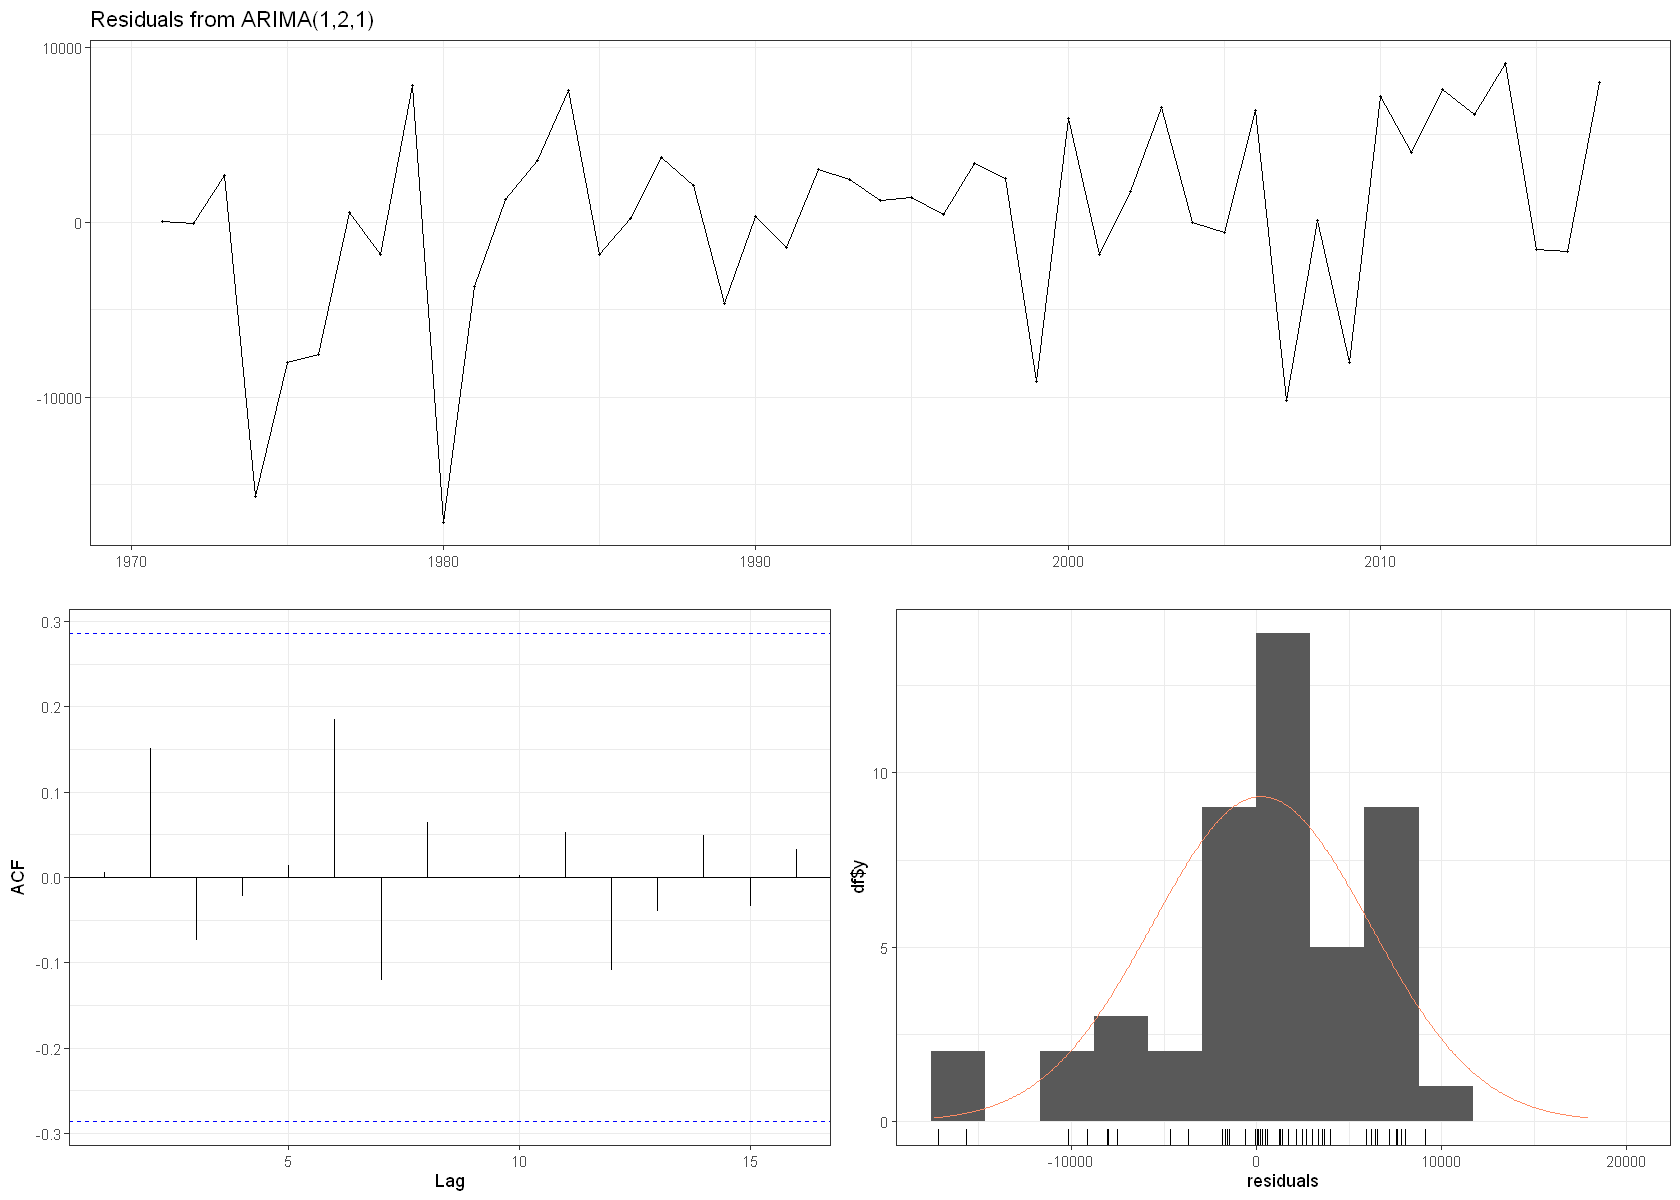

In [30]:
# --- Set Theme ---
theme_set(theme_bw())

# --- Canada - ARIMA (1,2,1) Ljung-Box Test ---
cat(' >> Canada : \n')
cat('**************\n ')
cat('.: ARIMA (1,2,1) Ljung-Box Test :.')
cat(reset(''))
checkresiduals(arima_can_121)

<ul>
It can be seen that there is no trend and seasonality in the plot (mean value is 0). <br>
There are no significant spikes in the ACF plot for the residuals, meaning there is no correlation between residuals in the ACF plot. <br>
The histogram of the residuals follows a normal distribution. <br>
The p-value is 0.7194, which is greater than 0.05. <br>
Conclusion: H₀ rejected
</ul>

 >> Canada : 
**************
 .: ARIMA (1,2,2) Ljung-Box Test :.
	Ljung-Box test

data:  Residuals from ARIMA(1,2,2)
Q* = 4.406, df = 6, p-value = 0.6219

Model df: 3.   Total lags used: 9



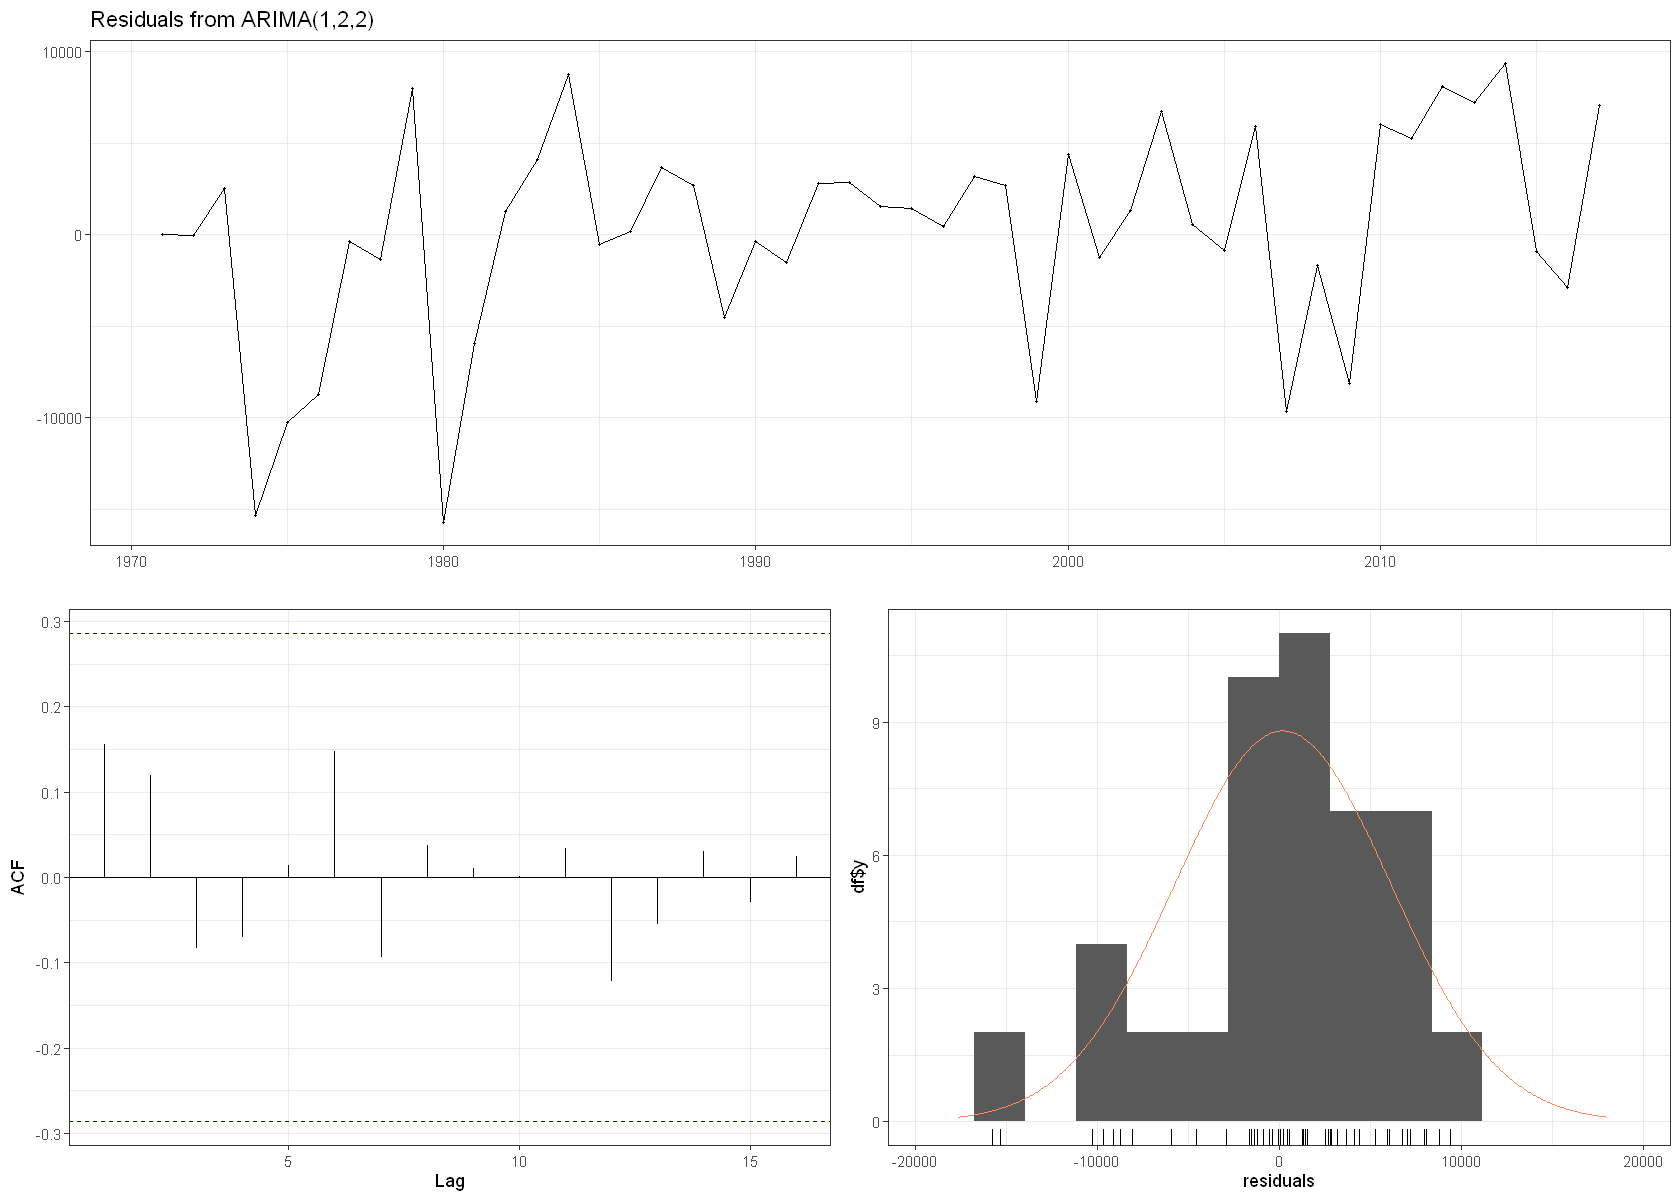

In [31]:
# --- Set Theme ---
theme_set(theme_bw())

# --- Canada - ARIMA (1,2,2) Ljung-Box Test ---
cat(' >> Canada : \n')
cat('**************\n ')
cat('.: ARIMA (1,2,2) Ljung-Box Test :.')
cat(reset(''))
checkresiduals(arima_can_122)

<ul>
It can be seen that there is no trend and seasonality in the plot (mean value is 0).<br>
There are no significant spikes in the ACF plot for the residuals, meaning there is no correlation between residuals in the ACF plot.<br>
The histogram of the residuals follows a normal distribution.<br>
The p-value is 0.6219, which is greater than 0.05.<br>
Conclusion: H₀ rejected
</ul>

 >> Germany : 
**************
 .: ARIMA (1,2,1) Ljung-Box Test :.
	Ljung-Box test

data:  Residuals from ARIMA(1,2,1)
Q* = 4.2913, df = 7, p-value = 0.7457

Model df: 2.   Total lags used: 9



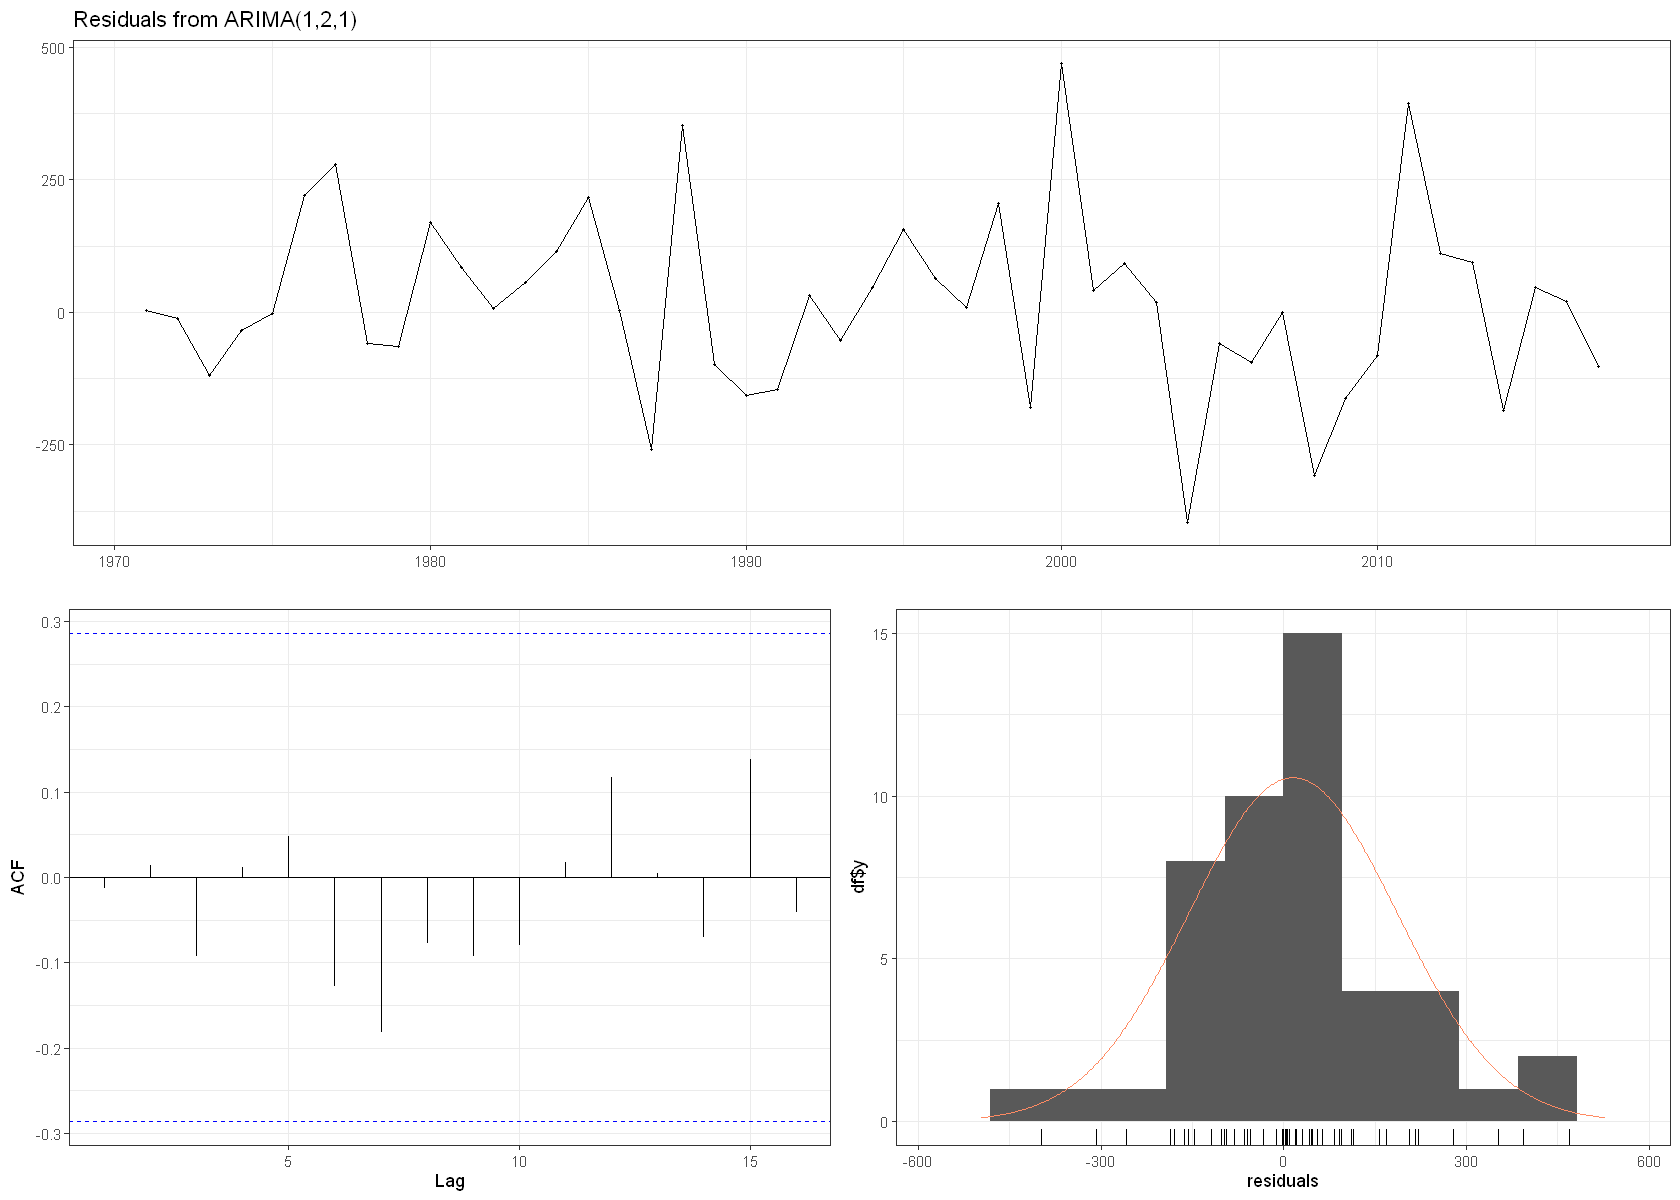

In [32]:
# --- Set Theme ---
theme_set(theme_bw())

# --- Germany - ARIMA (1,2,1) Ljung-Box Test ---
cat(' >> Germany : \n')
cat('**************\n ')
cat('.: ARIMA (1,2,1) Ljung-Box Test :.')
cat(reset(''))
checkresiduals(arima_deu_121)

<ul>
It can be seen that there is no trend and seasonality in the plot (mean value is 0).<br>
There are no significant spikes in the ACF plot for the residuals, meaning there is no correlation between residuals in the ACF plot.<br>
The histogram of the residuals follows a normal distribution.<br>
The p-value is 0.7457, which is greater than 0.05.<br>
Conclusion: H₀ rejected
</ul>

 >> Germany : 
**************
 .: ARIMA (1,2,2) Ljung-Box Test :.
	Ljung-Box test

data:  Residuals from ARIMA(1,2,2)
Q* = 4.1298, df = 6, p-value = 0.6591

Model df: 3.   Total lags used: 9



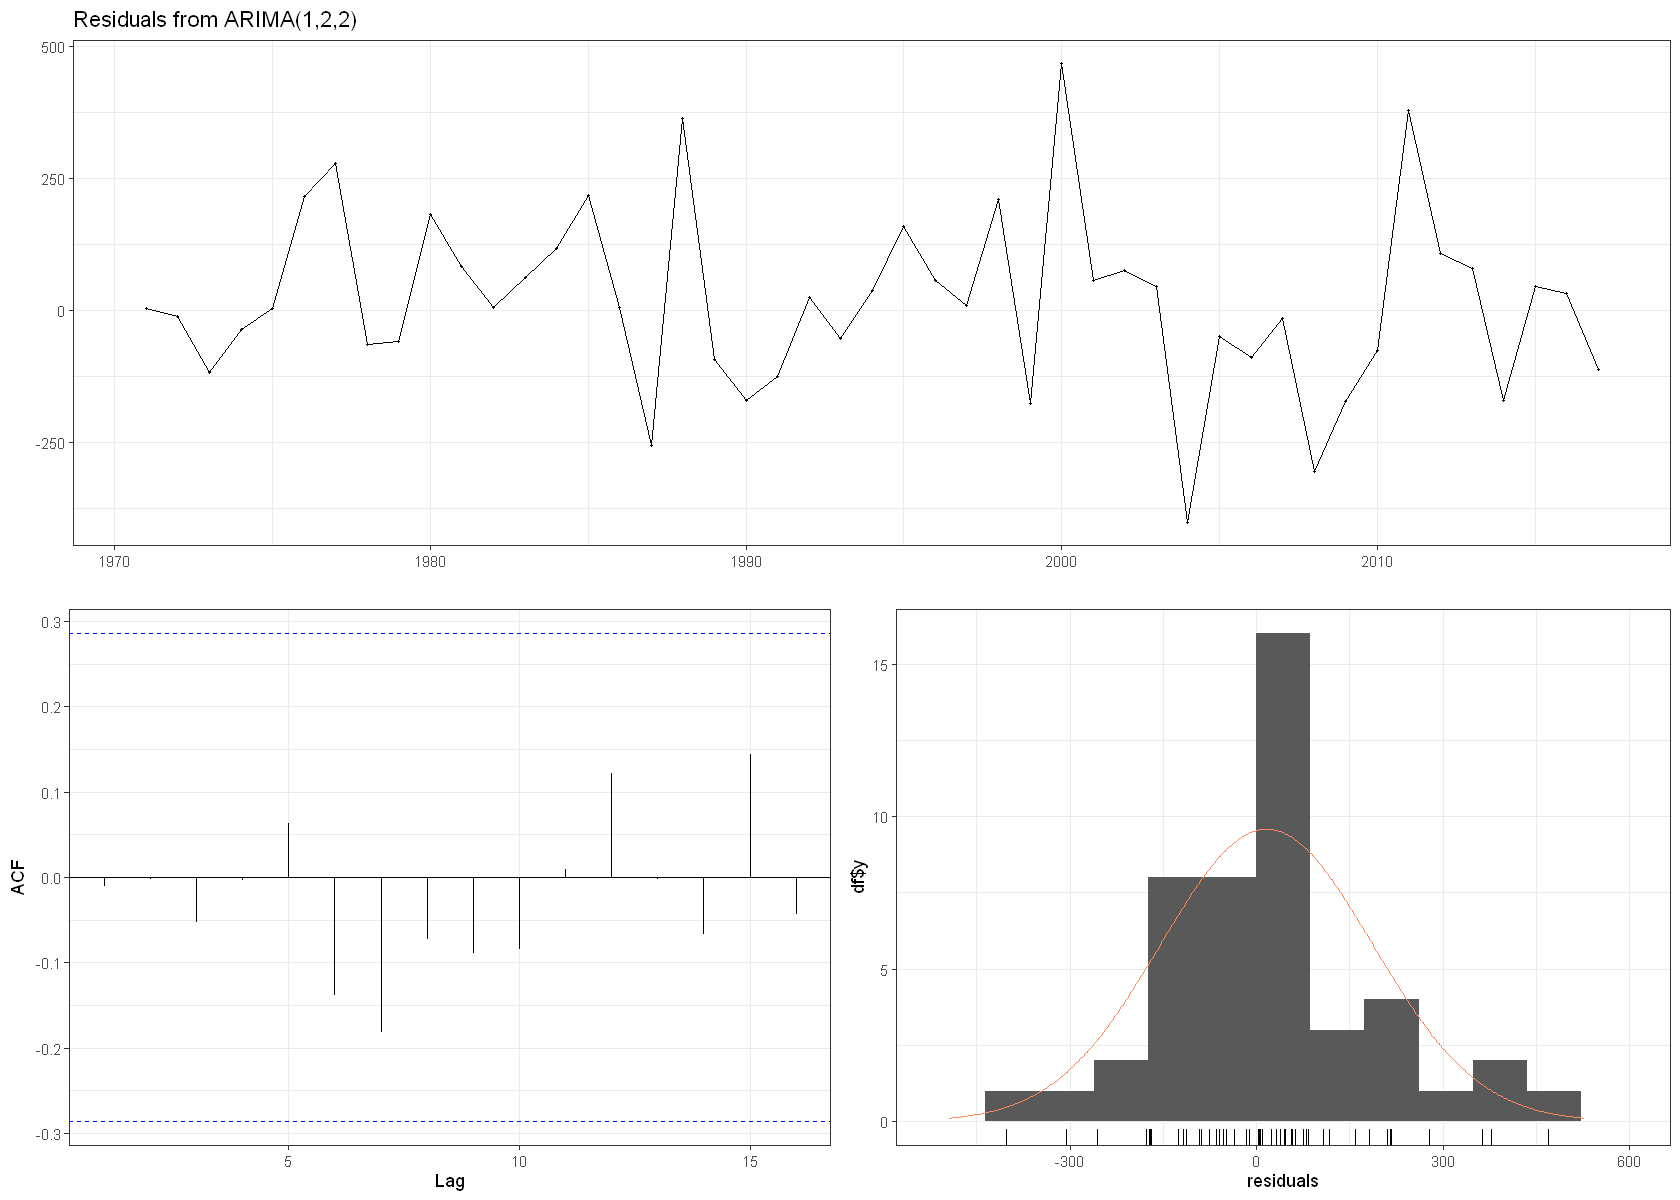

In [33]:
# --- Set Theme ---
theme_set(theme_bw())

# --- Germany - ARIMA (1,2,2) Ljung-Box Test ---
cat(' >> Germany : \n')
cat('**************\n ')
cat('.: ARIMA (1,2,2) Ljung-Box Test :.')
cat(reset(''))
checkresiduals(arima_deu_122)

<ul>
It can be seen that there is no trend and seasonality in the plot (mean value is 0).<br>
There are no significant spikes in the ACF plot for the residuals, meaning there is no correlation between residuals in the ACF plot.<br>
The histogram of the residuals follows a normal distribution.<br>
The p-value is 0.6591, which is greater than 0.05.<br>
Conclusion: H₀ rejected
</ul>

### 7.3.3 Significance of Parameter Coefficients 

In [34]:
# --- Canada - ARIMA Coefficient Tests ---
cat(' >> Canada : \n')
cat('**************\n ')
cat('.: ARIMA (1,2,1) Coefficient Test :.')
cat(reset(''))
coeftest(arima_can_121)
cat('.: ARIMA (1,2,2) Coefficient Test :.')
cat(reset(''))
coeftest(arima_can_122)

 >> Canada : 
**************
 .: ARIMA (1,2,1) Coefficient Test :.


z test of coefficients:

     Estimate Std. Error z value Pr(>|z|)    
ar1  0.169555   0.176557  0.9603   0.3369    
ma1 -0.888186   0.091134 -9.7460   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


.: ARIMA (1,2,2) Coefficient Test :.


z test of coefficients:

     Estimate Std. Error z value Pr(>|z|)  
ar1 -0.897200   0.393861 -2.2780  0.02273 *
ma1  0.052634   0.426059  0.1235  0.90168  
ma2 -0.743536   0.377360 -1.9704  0.04880 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


1️⃣ ARIMA (1,2,1)

<ul>
The coefficients of ma1 are significant because the p-value of the z-test is less than 0.05.<br>
The coefficient of ar1 is not significant because the p-value of the z-test is more than 0.05.<br>
It is suggested to revise the model or propose a new ARIMA model by including ma1.
</ul>
2️⃣ ARIMA (1,2,2)
<ul>
The coefficients of ar1 and ma2 are significant because the p-value of the z-test is less than 0.05.<br>
The coefficient of ma1 is not significant because the p-value of the z-test is more than 0.05.<br>
Since ma1 is not significant, but ma2 is significant, it is advised to revise the model by including ma1 and ma2.
</ul>

In [35]:
# --- Germany - ARIMA Coefficient Tests ---
cat(' >> Germany : \n')
cat('**************\n ')
cat('.: ARIMA (1,2,1) Coefficient Test :.')
cat(reset(''))
coeftest(arima_deu_121)
cat('.: ARIMA (1,2,2) Coefficient Test :.')
cat(reset(''))
coeftest(arima_deu_122)

 >> Germany : 
**************
 .: ARIMA (1,2,1) Coefficient Test :.


z test of coefficients:

    Estimate Std. Error z value Pr(>|z|)  
ar1 -0.16652    0.25846 -0.6443  0.51940  
ma1 -0.53887    0.24052 -2.2405  0.02506 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


.: ARIMA (1,2,2) Coefficient Test :.


z test of coefficients:

    Estimate Std. Error z value Pr(>|z|)
ar1 -0.59234    0.64125 -0.9237   0.3556
ma1 -0.11463    0.66983 -0.1711   0.8641
ma2 -0.28537    0.48811 -0.5846   0.5588


1️⃣ ARIMA (1,2,1)
<ul>
The coefficients of ma1 are significant because the p-value of the z-test is less than 0.05.<br>
The coefficient of ar1 is not significant because the p-value of the z-test is more than 0.05.<br>
It is suggested to revise the model or propose a new ARIMA model by including ma1.
</ul>
2️⃣ ARIMA (1,2,2)
<ul>
All the coefficients are not significant because the p-value of the z-test is more than 0.05.<br>
It is suggested to revise the model or propose a new ARIMA model.
</ul>

### 7.3.4 Accuracy 

In [36]:
# --- Canada - Accuracy ARIMA Models ---
cat(' >> Canada : \n')
cat('**************\n ')
cat('.: Acc. ARIMA (1,2,1) :.\n')
cat(reset(''))
accuracy(arima_can_121)
cat('.: Acc. ARIMA (1,2,2) :.\n')
cat(reset(''))
accuracy(arima_can_122)

 >> Canada : 
**************
 .: Acc. ARIMA (1,2,1) :.


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,252.8001,5825.414,4299.228,-0.1479867,4.886964,0.8291267,0.00569091


.: Acc. ARIMA (1,2,2) :.


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,186.7825,5887.42,4415.271,-0.2168723,5.035719,0.851506,0.1556451



Canada:
<ul>
RMSE, MAE, and MAPE generated by the ARIMA(1,2,1) model have lower values compared to ARIMA (1,2,2).<br>
It can be concluded that ARIMA (1,2,1) has the best accuracy.
</ul>

In [37]:
# --- Germany - Accuracy ARIMA Models ---
cat(' >> Germany : \n')
cat('**************\n ')
cat('.: Acc. ARIMA (1,2,1) :.\n')
cat(reset(''))
accuracy(arima_deu_121)
cat('.: Acc. ARIMA (1,2,1) :.\n')
cat(reset(''))
accuracy(arima_deu_122)

 >> Germany : 
**************
 .: Acc. ARIMA (1,2,1) :.


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,15.60203,169.79,125.0024,0.3461047,3.630782,0.664504,-0.01252289


.: Acc. ARIMA (1,2,1) :.


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,16.40772,169.3058,125.0218,0.3611468,3.621867,0.664607,-0.0107404


Germany:
<ul>
In general, forecast errors for both models are quite similar.<br>
However, some forecast errors in ARIMA(1,2,1) are lower compared to other models (lower values = better model/low error).<br>
It can be concluded that ARIMA(1,2,1) is the best model since ME, MAE, MPE, and MASE values are lower compared to ARIMA (1,2,2).
</ul>

### Conclusion:

<ul>
From previous ARIMA models comparison, it can be concluded that ARIMA(1,2,1) is the best model to be used in both countries since its relative performance, adequacy, accuracy, and significance of parameter coefficients are better compared to ARIMA(1,2,2).
</ul>

### 7.4 Forecasting using ARIMA (1,2,1) 

This section will carry out forecasting for the following ten periods for both countries (including the forecast plot and values).

.: Canada - Forecast Results (Best ARIMA) :.
*********************************************

     Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2018       181364.5 173559.4 189169.6 169427.6 193301.4
2019       187560.0 174873.6 200246.4 168157.8 206962.1
2020       193595.6 176642.0 210549.2 167667.3 219523.9
2021       199604.1 178640.9 220567.4 167543.6 231664.6
2022       205608.0 180735.1 230480.9 167568.2 243647.9
2023       211611.2 182851.2 240371.1 167626.6 255595.7
2024       217614.2 184948.2 250280.1 167655.9 267572.4
2025       223617.1 187002.2 260232.1 167619.4 279614.9
2026       229620.1 188998.5 270241.7 167494.7 291745.5
2027       235623.1 190927.9 280318.2 167267.7 303978.4

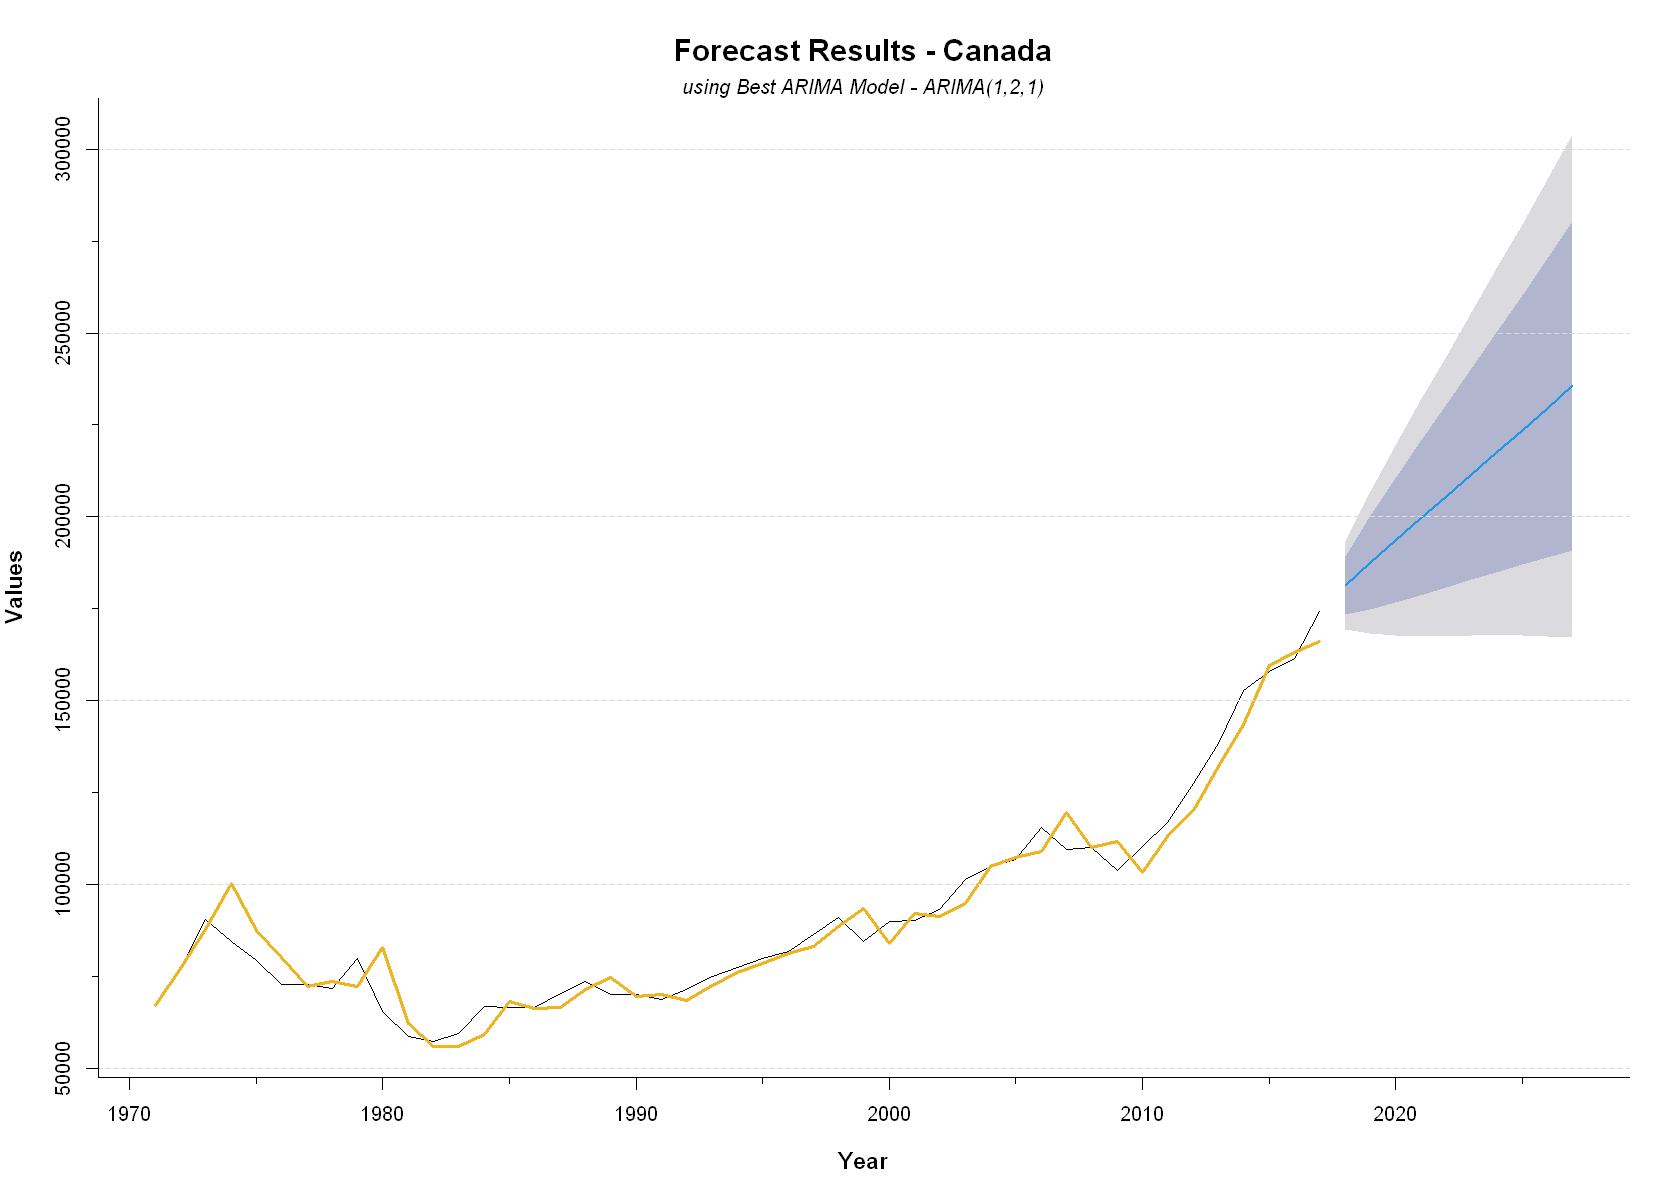

In [38]:
# --- Plot Best ARIMA Model ---
par(bg = 'white')  # Set background to white
plot(forecast(arima_can_121, h = 10), main = '', xlab = '', ylab = '', bty = 'L')
lines(fitted(arima_can_121), col = 'goldenrod2', lwd = 2.5)

# --- Plot Settings ---
grid(nx = NA, ny = NULL, lty = 2, col = 'gray85', lwd = 1)  # Keep a light gray grid
minor.tick(nx = 2, ny = 2, tick.ratio = 0.5)
title(main = 'Forecast Results - Canada', xlab = 'Year', ylab = 'Values', cex.main = 1.5, cex.lab = 1.15, font.lab = 2, col.main = 'black', col.lab = 'black')
title(main = 'using Best ARIMA Model - ARIMA(1,2,1)', cex.main = 1, font.main = 3, line = 0.2, col.main = 'black')

# --- Forecast Results using Best ARIMA Models ---
cat('.: Canada - Forecast Results (Best ARIMA) :.\n')
cat('*********************************************')
forecast(arima_can_121, h = 10)
cat(reset('\n'))


.: Germany - Forecast Results (Best ARIMA) :.
*********************************************

     Point Forecast     Lo 80    Hi 80      Lo 95    Hi 95
2018       2135.008 1907.5175 2362.498  1787.0914 2482.924
2019       2030.461 1658.3206 2402.602  1461.3213 2599.601
2020       1927.942 1390.1417 2465.742  1105.4476 2750.436
2021       1825.084 1105.8642 2544.305   725.1320 2925.037
2022       1722.284  806.0835 2638.484   321.0765 3123.491
2023       1619.473  491.7710 2747.176  -105.1985 3344.145
2024       1516.665  163.7618 2869.567  -552.4216 3585.751
2025       1413.856 -177.2107 3004.922 -1019.4703 3847.181
2026       1311.047 -530.5085 3152.602 -1505.3689 4127.462
2027       1208.238 -895.5731 3312.048 -2009.2632 4425.739

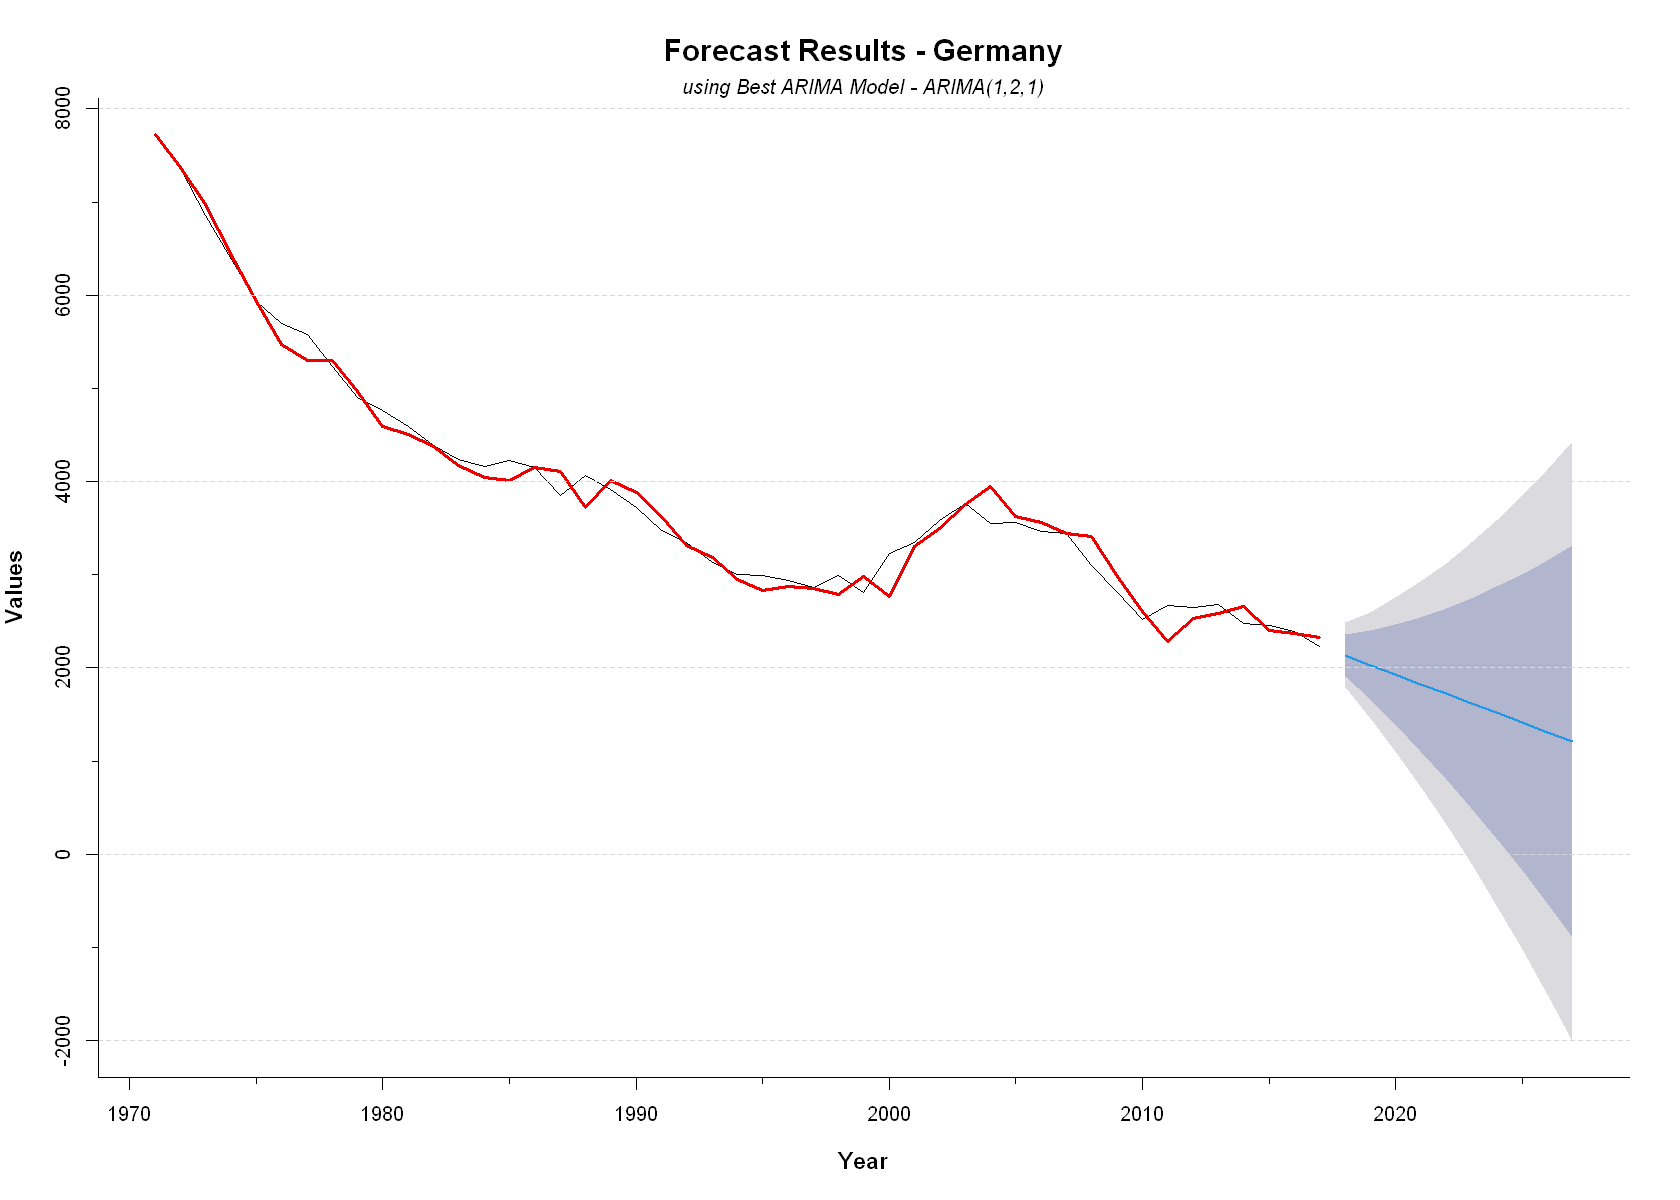

In [39]:
# --- Plot Best ARIMA Model ---
par(bg = 'white')  # Set background to white
plot(forecast(arima_deu_121, h = 10), main = '', xlab = '', ylab = '', bty = 'L')
lines(fitted(arima_deu_121), col = 'red2', lwd = 2.5)

# --- Plot Settings ---
grid(nx = NA, ny = NULL, lty = 2, col = 'gray85', lwd = 1)  # Keep a light gray grid
minor.tick(nx = 2, ny = 2, tick.ratio = 0.5)
title(main = 'Forecast Results - Germany', xlab = 'Year', ylab = 'Values', cex.main = 1.5, cex.lab = 1.15, font.lab = 2, col.main = 'black', col.lab = 'black')
title(main = 'using Best ARIMA Model - ARIMA(1,2,1)', cex.main = 1, font.main = 3, line = 0.2, col.main = 'black')

# --- Forecast Results using Best ARIMA Models ---
cat('.: Germany - Forecast Results (Best ARIMA) :.\n')
cat('*********************************************')
forecast(arima_deu_121, h = 10)
cat(reset('\n'))
